<a href="https://colab.research.google.com/github/Yashina-Yulia/projects_pub/blob/main/telecom_churn_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Описание проекта

Оператор связи «Ниединогоразрыва.ком» планирует уменьшить отток абонентской базы для улучшения бизнес показателей.

Чтобы сократить отток и сохранить имеющихся клиентов, компании важно понимать, кто из клиентов находится в зоне риска. В этом случае оператор может сфокусировать усилия на персональных предложениях, предотвратив расставание.

Для этого необходимо научиться прогнозировать отток клиентов, иначе: задумывается ли клиент об уходе? В распоряжении есть следующие данные о клиентах:

- contract_new.csv — информация о договоре;
- personal_new.csv — персональные данные клиента;
- internet_new.csv — информация об интернет-услугах;
- phone_new.csv — информация об услугах телефонии.

**Цель проекта**:

построить модель, которая будет прогнозировать потенциальный уход клиента, основываясь имеющейся о нем информации в базе. Задача классификации. Требуемая эффективность модели: AUC_ROC >0.85

**План проекта**:

1. Описание проекта
2. Знакомстов с данными
- Первичная проверка данных
- Предобработка и создание дополнительных признаков
3. Исследовательский анализ данных
- Профилирование данных
- Исследование дисбаланса классов
- Проверка на корреляцию
- Кластеризация
4. Обучение моделей
- Подготовка данных для моделирования
- Построение моделей
  - Случайный Лес
  - Логистическая регрессия
  - Бустинг LGBM, Catboost
5. Тестирование выбранной модели
- Проверка на тестовой выборке
- Проверка модели на адекватность
- Оценка влияния предсказаний на бизнес метрики
6. Отчет по проекту

## Знакомство с данными

In [ ]:
!pip install scikit-learn
!pip install matplotlib
!pip install seaborn
!pip install phik
!pip install catboost
!pip install pandas-profiling

In [ ]:
# имортируем необходимые библиотеки
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

#from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier

import lightgbm as lgb
from lightgbm import LGBMClassifier

import catboost as cat
from catboost import CatBoostClassifier, Pool

import warnings

import tqdm
from tqdm import notebook, tqdm, tqdm_gui, trange
from time import sleep

import phik
from phik import resources, report

from pandas_profiling import ProfileReport

#from sklearn.cluster import KMeans

/tmp/ipykernel_858/4115896951.py:45: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  from pandas_profiling import ProfileReport


In [ ]:
# записываем исходные данные в переменные
df_contract = pd.read_csv('/datasets/contract_new.csv')
df_personal = pd.read_csv('/datasets/personal_new.csv')
df_internet = pd.read_csv('/datasets/internet_new.csv')
df_phone = pd.read_csv('/datasets/phone_new.csv')

### Первичная проверка данных

In [ ]:
# знакомимся с информацией из файла о Контрактах
df_contract.head(10)

customerID   BeginDate     EndDate            Type PaperlessBilling  \
0  7590-VHVEG  2020-01-01          No  Month-to-month              Yes   
1  5575-GNVDE  2017-04-01          No        One year               No   
2  3668-QPYBK  2019-10-01          No  Month-to-month              Yes   
3  7795-CFOCW  2016-05-01          No        One year               No   
4  9237-HQITU  2019-09-01          No  Month-to-month              Yes   
5  9305-CDSKC  2019-03-01          No  Month-to-month              Yes   
6  1452-KIOVK  2018-04-01          No  Month-to-month              Yes   
7  6713-OKOMC  2019-04-01          No  Month-to-month               No   
8  7892-POOKP  2017-07-01          No  Month-to-month              Yes   
9  6388-TABGU  2014-12-01  2017-05-01        One year               No   

               PaymentMethod  MonthlyCharges TotalCharges  
0           Electronic check           29.85        31.04  
1               Mailed check           56.95      2071.84  
2               Mailed check           53.85       226.17  
3  Bank transfer (automatic)           42.30       1960.6  
4           Electronic check           70.70        353.5  
5           Electronic check           99.65      1150.96  
6    Credit card (automatic)           89.10      2058.21  
7               Mailed check           29.75       300.48  
8           Electronic check          104.80      3573.68  
9  Bank transfer (automatic)           56.15      1628.35

In [ ]:
df_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [ ]:
# проверяем на дубликаты
df_contract.duplicated().sum()

0

In [ ]:
#Проверим содержание категориальных признаков
display(
    df_contract['Type'].unique(), 
    df_contract['PaperlessBilling'].unique(), 
    df_contract['PaymentMethod'].unique()
)

array(['Month-to-month', 'One year', 'Two year'], dtype=object)

array(['Yes', 'No'], dtype=object)

array(['Electronic check', 'Mailed check', 'Bank transfer (automatic)',
       'Credit card (automatic)'], dtype=object)

In [ ]:
#посмотрим распределение количественных
df_contract['MonthlyCharges'].describe()

count    7043.000000
mean       64.761692
std        30.090047
min        18.250000
25%        35.500000
50%        70.350000
75%        89.850000
max       118.750000
Name: MonthlyCharges, dtype: float64

In [ ]:
df_contract['TotalCharges'].describe()

count     7043
unique    6658
top           
freq        11
Name: TotalCharges, dtype: object

*Датасет Контракты:*

- 7043 записей
- пропусков нет, явных дубликатов нет
- 8 признаков, большинство из которых имеет формат object (включая признаки с датами и расходы, выраженные в вещественных числах)
- датасет содержит целевой признак - дату завершения договора обслуживания (или его отсутствие), но признак выражен не явно и в текущем виде не может быть исользован для классификации

Для дальнейшей работы с датасетом требуется:
- изменение форматов для дат начала и завершения обслуживания - на datetime, изменение формата расходов TotalCharges на float
- создание целевого признака на основе даты завершения контракта
- создание дополнительного признака длительности обслуживания, косвенно характерезующего лояльность клиента 

In [ ]:
# знакомимся с информацией из файла о персональных данных
df_personal.head(10)

customerID  gender  SeniorCitizen Partner Dependents
0  7590-VHVEG  Female              0     Yes         No
1  5575-GNVDE    Male              0      No         No
2  3668-QPYBK    Male              0      No         No
3  7795-CFOCW    Male              0      No         No
4  9237-HQITU  Female              0      No         No
5  9305-CDSKC  Female              0      No         No
6  1452-KIOVK    Male              0      No        Yes
7  6713-OKOMC  Female              0      No         No
8  7892-POOKP  Female              0     Yes         No
9  6388-TABGU    Male              0      No        Yes

In [ ]:
# знакомимся с информацией из файла о персональных данных
df_personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [ ]:
# проверяем на дубликаты
df_personal.duplicated().sum()

0

In [ ]:
# проверка содержания для object
display(
    df_personal['gender'].unique(), 
    df_personal['Partner'].unique(), 
    df_personal['Dependents'].unique(),
    df_personal['SeniorCitizen'].unique()
)

array(['Female', 'Male'], dtype=object)

array(['Yes', 'No'], dtype=object)

array(['No', 'Yes'], dtype=object)

array([0, 1])

*Датасет Перс данные:*

содержит 7043 записей, без явных дубликатов и пропусков
5 признаков, включая идентификатор клиента
оставшиеся 4 представляют собой бинарные классификации, но записанные разными способами. Часть признаков object, статус пенсионера целое число (0 или 1)

In [ ]:
# знакомимся с информацией из файла об использовании интернет-услуг
df_internet.head(10)

customerID InternetService OnlineSecurity OnlineBackup DeviceProtection  \
0  7590-VHVEG             DSL             No          Yes               No   
1  5575-GNVDE             DSL            Yes           No              Yes   
2  3668-QPYBK             DSL            Yes          Yes               No   
3  7795-CFOCW             DSL            Yes           No              Yes   
4  9237-HQITU     Fiber optic             No           No               No   
5  9305-CDSKC     Fiber optic             No           No              Yes   
6  1452-KIOVK     Fiber optic             No          Yes               No   
7  6713-OKOMC             DSL            Yes           No               No   
8  7892-POOKP     Fiber optic             No           No              Yes   
9  6388-TABGU             DSL            Yes          Yes               No   

  TechSupport StreamingTV StreamingMovies  
0          No          No              No  
1          No          No              No  
2          No          No              No  
3         Yes          No              No  
4          No          No              No  
5          No         Yes             Yes  
6          No         Yes              No  
7          No          No              No  
8         Yes         Yes             Yes  
9          No          No              No

In [ ]:
df_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [ ]:
df_internet.duplicated().sum()

0

In [ ]:
# проверка содержания для object
display(
    df_internet['InternetService'].unique(), 
    df_internet['OnlineSecurity'].unique(), 
    df_internet['OnlineBackup'].unique(),
    df_internet['DeviceProtection'].unique(),
    df_internet['TechSupport'].unique(), 
    df_internet['StreamingTV'].unique(),
    df_internet['StreamingMovies'].unique()    
)

array(['DSL', 'Fiber optic'], dtype=object)

array(['No', 'Yes'], dtype=object)

array(['Yes', 'No'], dtype=object)

array(['No', 'Yes'], dtype=object)

array(['No', 'Yes'], dtype=object)

array(['No', 'Yes'], dtype=object)

array(['No', 'Yes'], dtype=object)

*Датасет использование Интернет-услуг:*

5517 записей, а значит не для всех пользователей есть данные об услугах интернет, соотв-но пользователи не попавшие в датасет не пользуются интернетом с данным оператором
очевидных пропусков нет, явных дубликатов нет
все 8 признаков object, при этом 7 бинарные: пользуется или не пользуется услугами и способ подключения

In [ ]:
# знакомимся с информацией из файла о телефонии
df_phone.head(10)

customerID MultipleLines
0  5575-GNVDE            No
1  3668-QPYBK            No
2  9237-HQITU            No
3  9305-CDSKC           Yes
4  1452-KIOVK           Yes
5  7892-POOKP           Yes
6  6388-TABGU            No
7  9763-GRSKD            No
8  7469-LKBCI            No
9  8091-TTVAX           Yes

In [ ]:
df_phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [ ]:
df_phone.duplicated().sum()

0

In [ ]:
df_phone['MultipleLines'].unique()

array(['No', 'Yes'], dtype=object)

*Датасет услуги телефонии:*

6361 записей, аналогично интернету - предоложим, что не все пользователи прибегают к данным услугам
Кроме идентификатора клиента в базе всего один бинарный признак в формате object, использование услуги нескольких линий
Все датасеты связывает уникальный идентификатор клиента, по которому датасеты будут объединены. Проверим все датасеты на уникальность идентификатора, чтобы убедиться в отсутствии дубликатов.

Идентификатор сочетание 4 цифр, дефиса, 5 заглавных латинских букв. Для проверки приведем к нижнему регистру

In [ ]:
display(
    df_contract['customerID'].str.lower().duplicated().sum(), 
    df_personal['customerID'].str.lower().duplicated().sum(), 
    df_internet['customerID'].str.lower().duplicated().sum(), 
    df_phone['customerID'].str.lower().duplicated().sum()
)

0

0

0

0

Дубликатов в идентификаторах не выявлено

### Предобработка и создание дополнительных признаков

В датасете Контракты есть несколько признаков с некорректными форматами. Исправим это, но сначала выделим целевой признак, пользуясь информацией о дате завершения контракта

In [ ]:
# создадим целевой признак, свидетельствующий об уходе клиента 
df_contract['Churn'] = 1
# если в поле дата завершения стоит No, значит клиент остался
df_contract.loc[df_contract['EndDate']=='No', 'Churn'] = 0

# проверим баланс классов
round(df_contract['Churn'].sum()/df_contract['Churn'].count() * 100, 2)

15.63

15.6% клиентов телекома ушли за рассматриваемый период.

In [ ]:
# заменим дату завершения контракта на дату выгрузки данных
df_contract.loc[df_contract['EndDate']=='No', 'EndDate'] = '2020-02-01'

# переведем в корректный формат datetime
df_contract['BeginDate'] = pd.to_datetime(df_contract['BeginDate'], format='%Y-%m-%d')
df_contract['EndDate'] = pd.to_datetime(df_contract['EndDate'], format='%Y-%m-%d')
   
# вычислим время обслуживания каждого клиента    
df_contract['Duration'] = (df_contract['EndDate'] - df_contract['BeginDate']).dt.days

df_contract.head()

customerID  BeginDate    EndDate            Type PaperlessBilling  \
0  7590-VHVEG 2020-01-01 2020-02-01  Month-to-month              Yes   
1  5575-GNVDE 2017-04-01 2020-02-01        One year               No   
2  3668-QPYBK 2019-10-01 2020-02-01  Month-to-month              Yes   
3  7795-CFOCW 2016-05-01 2020-02-01        One year               No   
4  9237-HQITU 2019-09-01 2020-02-01  Month-to-month              Yes   

               PaymentMethod  MonthlyCharges TotalCharges  Churn  Duration  
0           Electronic check           29.85        31.04      0        31  
1               Mailed check           56.95      2071.84      0      1036  
2               Mailed check           53.85       226.17      0       123  
3  Bank transfer (automatic)           42.30       1960.6      0      1371  
4           Electronic check           70.70        353.5      0       153

Проверим содержание временных признаков. Период EndDate не выходит за границы признака Начал обслуживания, аномальных значений также не наблюдается

In [ ]:
df_contract['BeginDate'].describe(datetime_is_numeric=True)

count                             7043
mean     2017-04-30 13:01:50.918642688
min                2013-10-01 00:00:00
25%                2015-06-01 00:00:00
50%                2017-09-01 00:00:00
75%                2019-04-01 00:00:00
max                2020-02-01 00:00:00
Name: BeginDate, dtype: object

In [ ]:
df_contract['EndDate'].describe(datetime_is_numeric=True)

count                             7043
mean     2019-10-16 02:22:05.912253440
min                2014-06-01 00:00:00
25%                2020-02-01 00:00:00
50%                2020-02-01 00:00:00
75%                2020-02-01 00:00:00
max                2020-02-01 00:00:00
Name: EndDate, dtype: object

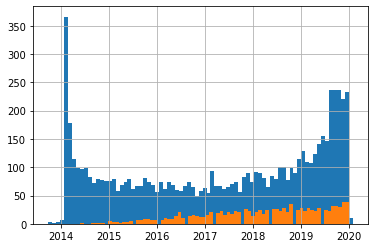

In [ ]:
df_contract['BeginDate'].hist(bins=77)
df_contract[df_contract['EndDate'] !='2020-02-01']['EndDate'].hist(bins=77);

Переведем признак TotalCharges в формат вещественных чисел, но прежде найдем причину, почему данные носят формат Object

In [ ]:
# отсортируем данные в столбце
display(df_contract['TotalCharges'].sort_values())

# посчитаем сколько пробелов есть в признаке, именно они мешают поменять формат
display(df_contract.loc[(df_contract['TotalCharges']==' ')]['TotalCharges'].count())

3331          
4380          
6670          
488           
3826          
         ...  
2880    997.78
3267    998.89
6023     999.6
1700     999.6
1625     999.9
Name: TotalCharges, Length: 7043, dtype: object

11

До проведени яисследовательского анализа причина появления пропусков в данных неочевидна. Предварительно заполним 11 пропусков нулями, а затем вернемся к ним в процессе EDA

In [ ]:
df_contract.loc[(df_contract['TotalCharges']==' '),'TotalCharges'] = 0
df_contract['TotalCharges'] = df_contract['TotalCharges'].astype(float)

df_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   Churn             7043 non-null   int64         
 9   Duration          7043 non-null   int64         
dtypes: datetime64[ns](2), float64(2), int64(2), object(4)
memory usage: 550.4+ KB


Данные готовы к объединению и дальнейшему проведению исследовательского анализа.

## Исследовательский анализ данных

Объединим 4 датасета по идентификатору customerID. В df_contract содержится целевой признак, поэтому он должен полностью войти в объединенную базу.

In [ ]:
# объединяем базы в единый датасет, в основе df_contract
df = df_contract.merge(df_personal, on='customerID', how='left')
# проверяем как прошло объединение
display(df.shape)

df = df.merge(df_internet, on='customerID', how='left')
display(df.shape)

df = df.merge(df_phone, on='customerID', how='left')
df.info()

(7043, 14)

(7043, 21)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   Churn             7043 non-null   int64         
 9   Duration          7043 non-null   int64         
 10  gender            7043 non-null   object        
 11  SeniorCitizen     7043 non-null   int64         
 12  Partner           7043 non-null   object        
 13  Dependents        7043 non-null   object        
 14  InternetService   5517 n

В результате объединения получился датасет, состоящий из 7043 записей и 22 признаков, включая целевой. Датасеты с информацией о контрактах и перс данных объединились полностью по всем записям (все ID совпали), датасеты по интернет услугам и телефонии также вошли полностью, но так как число записей там было меньше, появились пропуски для клиентов, не пользующихся теми или иными услугами. Заполним их

Почти все признаки, где появились пропуски, бинарные и содержат Yes\No. Так как пользователи не пользуются услугами заполним пропуски - No. Один признак содержит один из двух типов соединения с интернетом, для непользующихся также проставим No.

После замены пользователей интернета можно будет отфильтровать по признаку InternetService, где стоит ип соединения, но при заполнении пропусков для телефонии в единственном признаке MultipleLines пользователи телефонии, не пользующиеся услугой, смешаются с теми, кто в принципе не подключал данную услугу. Чтобы не потерять пользователей телефонии, создадим дополнительный признак - Phone

In [ ]:
df['Phone'] = 'Yes'
df.loc[df['MultipleLines'].isna(), 'Phone'] = 'No'

display(df[df['Phone']=='Yes']['Churn'].count())

# запишем названия признаков в список и пройдем по нему, заменяя пропуски
feats = df_internet.columns[1:].append(df_phone.columns[1:])
display(list)

for feat in feats:
    df.loc[df[feat].isna(), feat] = 'No'

# проверим отсутствие пропусков    
df.isna().sum()    

6361

list

customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
Duration            0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
MultipleLines       0
Phone               0
dtype: int64

Данные объединены, пропусков нет, переходим к анализу содержания

### Профилирование данных

Проведем первичный анализ с помощью виджета pandas profiling

In [ ]:
profile = ProfileReport(df, title="Pandas Profiling Report")
profile.to_widgets()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

Сделаем выводы из профилирования и дополним его при необходимости. В нашем распоряжении 15 категориальных (включая бинарные в формате Boolean), 3 количественных признака и два в формате времени. Посмотрим на каждый из них.

**Type (тип оплаты)**: наиболее частотный способ оплаты - помесячный, его придерживаются 55% клиентов.

In [ ]:
#считаем как клиенты распределяются по Типам платежей
display(round(df.groupby('Type')['Churn'].count()/df.shape[0], 2))

Type
Month-to-month    0.55
One year          0.21
Two year          0.24
Name: Churn, dtype: float64

**PaperlessBilling (безналичный расчет)**: большая часть клиентов пользуется безналичным расчетом, 60%

In [ ]:
round(df.groupby('PaperlessBilling')['Churn'].count()/df.shape[0], 2)

PaperlessBilling
No     0.41
Yes    0.59
Name: Churn, dtype: float64

**PaymentMethod (способ оплаты)**: наиболее частотный вариант - electronic check, им пользуется 1/3 клиентов. Остальные три способа: (архаичный) Mailed check (оплата по почте), и автоматическое списание с карты или отправка банком (наиболее стабильные платежи) составляют примерно по 22%.

При этом, все способы оплаты могут быть как наличными, так и безналичными. Электронные платежи имеют преимущества скорости безналичных платежей (75% проходит так). Автоматические переводы на 58% безналичны и почти 60% оплат "почтой" проходит наличными.

Вероятно, что совершение безналичных расчетов (скорость поступления на счет и уменьшение издержек по логистике наличности) более выгодно телеком кампании.

In [ ]:
round(df.groupby('PaymentMethod')['Churn'].count()/df.shape[0], 2)

PaymentMethod
Bank transfer (automatic)    0.22
Credit card (automatic)      0.22
Electronic check             0.34
Mailed check                 0.23
Name: Churn, dtype: float64

In [ ]:
# распределние по безналичным и наличным платежам
for i in df['PaymentMethod'].unique():
    display(i, round(df[df['PaymentMethod']==i].groupby('PaperlessBilling')['Churn'].count()/
              df[df['PaymentMethod']==i].shape[0], 2))

'Electronic check'

PaperlessBilling
No     0.26
Yes    0.74
Name: Churn, dtype: float64

'Mailed check'

PaperlessBilling
No     0.59
Yes    0.41
Name: Churn, dtype: float64

'Bank transfer (automatic)'

PaperlessBilling
No     0.42
Yes    0.58
Name: Churn, dtype: float64

'Credit card (automatic)'

PaperlessBilling
No     0.42
Yes    0.58
Name: Churn, dtype: float64

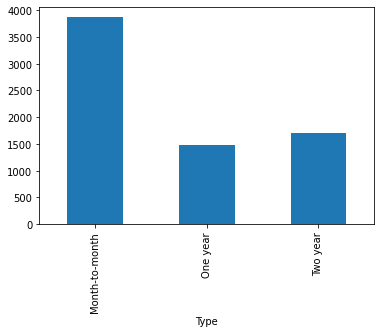

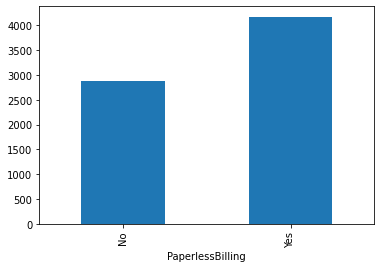

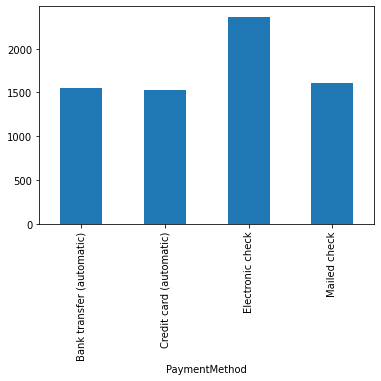

In [ ]:
# выведем признаки, относящие к группе Contract 
for i in ['Type', 'PaperlessBilling', 'PaymentMethod']:
    plt.show(df.groupby(i)['Churn'].count().plot(kind='bar'))

**MonthlyCharges (расходы за месяц)**: минимальное значение 18.25, максимальное 118.75. Медианное значение (70.35) выше среднего (64.8), значит превалируют пользователи с меньшей суммой чека, что заметно и на диаграмме

In [ ]:
df['MonthlyCharges'].describe()

count    7043.000000
mean       64.761692
std        30.090047
min        18.250000
25%        35.500000
50%        70.350000
75%        89.850000
max       118.750000
Name: MonthlyCharges, dtype: float64

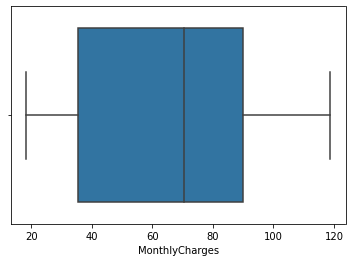

In [ ]:
sns.boxplot(x=df['MonthlyCharges']);

**TotalCharges (расходы за все время)**: минимальное значение - 0 (таких пользователей 11, это новые пользователи, пришедшие в феврале 2020, когда была сделана выгрузка), максимальное значение 9221.4. В отличие от помесячных расходов среднее (2115) выше медианы (1343), а также наблюдается ряд аномального высоких значений (есть группа пользователей, вытягивающих среднее значение вверх засчет длительности обслуживания или более высокой стоимости платы, или засчет обоих факторв сразу)

In [ ]:
df[df['TotalCharges']==0]

customerID  BeginDate    EndDate      Type PaperlessBilling  \
488   4472-LVYGI 2020-02-01 2020-02-01  Two year              Yes   
753   3115-CZMZD 2020-02-01 2020-02-01  Two year               No   
936   5709-LVOEQ 2020-02-01 2020-02-01  Two year               No   
1082  4367-NUYAO 2020-02-01 2020-02-01  Two year               No   
1340  1371-DWPAZ 2020-02-01 2020-02-01  Two year               No   
3331  7644-OMVMY 2020-02-01 2020-02-01  Two year               No   
3826  3213-VVOLG 2020-02-01 2020-02-01  Two year               No   
4380  2520-SGTTA 2020-02-01 2020-02-01  Two year               No   
5218  2923-ARZLG 2020-02-01 2020-02-01  One year              Yes   
6670  4075-WKNIU 2020-02-01 2020-02-01  Two year               No   
6754  2775-SEFEE 2020-02-01 2020-02-01  Two year              Yes   

                  PaymentMethod  MonthlyCharges  TotalCharges  Churn  \
488   Bank transfer (automatic)           52.55           0.0      0   
753                Mailed check           20.25           0.0      0   
936                Mailed check           80.85           0.0      0   
1082               Mailed check           25.75           0.0      0   
1340    Credit card (automatic)           56.05           0.0      0   
3331               Mailed check           19.85           0.0      0   
3826               Mailed check           25.35           0.0      0   
4380               Mailed check           20.00           0.0      0   
5218               Mailed check           19.70           0.0      0   
6670               Mailed check           73.35           0.0      0   
6754  Bank transfer (automatic)           61.90           0.0      0   

      Duration  ... Dependents  InternetService OnlineSecurity OnlineBackup  \
488          0  ...        Yes              DSL            Yes           No   
753          0  ...        Yes               No             No           No   
936          0  ...        Yes              DSL            Yes          Yes   
1082         0  ...        Yes               No             No           No   
1340         0  ...        Yes              DSL            Yes          Yes   
3331         0  ...        Yes               No             No           No   
3826         0  ...        Yes               No             No           No   
4380         0  ...        Yes               No             No           No   
5218         0  ...        Yes               No             No           No   
6670         0  ...        Yes              DSL             No          Yes   
6754         0  ...        Yes              DSL            Yes          Yes   

     DeviceProtection TechSupport StreamingTV StreamingMovies MultipleLines  \
488               Yes         Yes         Yes              No            No   
753                No          No          No              No            No   
936               Yes          No         Yes             Yes            No   
1082               No          No          No              No           Yes   
1340              Yes         Yes         Yes              No            No   
3331               No          No          No              No            No   
3826               No          No          No              No           Yes   
4380               No          No          No              No            No   
5218               No          No          No              No            No   
6670              Yes         Yes         Yes              No           Yes   
6754               No         Yes          No              No           Yes   

     Phone  
488     No  
753    Yes  
936    Yes  
1082   Yes  
1340    No  
3331   Yes  
3826   Yes  
4380   Yes  
5218   Yes  
6670   Yes  
6754   Yes  

[11 rows x 23 columns]

In [ ]:
# посмотрим распределение
df['TotalCharges'].describe()

count    7043.000000
mean     2115.312885
std      2112.742814
min         0.000000
25%       436.750000
50%      1343.350000
75%      3236.690000
max      9221.380000
Name: TotalCharges, dtype: float64

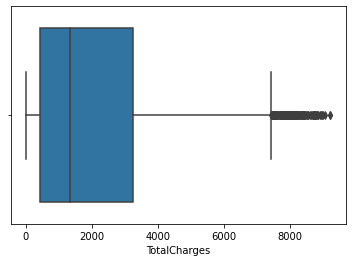

In [ ]:
sns.boxplot(x=df['TotalCharges']);

Наиболее **сильное влияние** на стоимость услуг за месяц оказывает наличие интернета в пакете (корреляция 0.88), а также отдельных услуг: стриминга (корреляция выше 0.67), телефонии (0.66). Общая стоимость сильно корреклирует с продолжительностью обслуживания (0.87), что логично, а также с объемом месячной платы (корреляция выше средней 0.65)

**Gender (пол)**: Распределение клиентов по полу очень близко к равному 50\50

**SeniorCitizen (наличие пенсионного статуса по возрасту)**: среди клиентов только 16% имеют статус пенсионера

In [ ]:
round(df.groupby('SeniorCitizen')['Churn'].count()/df.shape[0], 2)

SeniorCitizen
0    0.84
1    0.16
Name: Churn, dtype: float64

**Partner (наличие супруга(и))**: клиенты практичеки поровну делятся на состоящих в браке и нет, с небольшим перевесом холостых клиентов

In [ ]:
round(df.groupby('Partner')['Churn'].count()/df.shape[0], 2)

Partner
No     0.52
Yes    0.48
Name: Churn, dtype: float64

**Dependents (наличие иждивенцев)**: 70% клиентов не имеют иждивенцов

In [ ]:
round(df.groupby('Dependents')['Churn'].count()/df.shape[0], 2)

Dependents
No     0.7
Yes    0.3
Name: Churn, dtype: float64

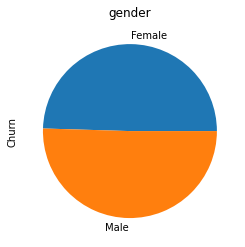

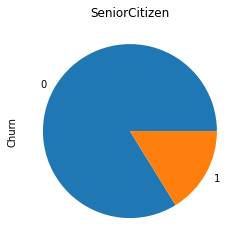

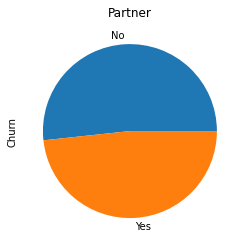

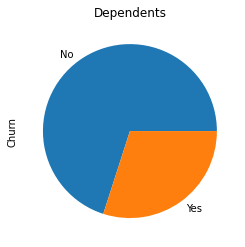

In [ ]:
# выведем признаки, относящие к группе Personal 
for i in ['gender', 'SeniorCitizen', 'Partner', 'Dependents']:
    plt.title(i)
    plt.show(df.groupby(i)['Churn'].count().plot(kind='pie'))

Предварительный **демографический портрет** "среднего" пользователя: это человек трудоспособного возраста, равно мужчина или женщина, равно в браке или нет, без иждивенцов. Так как под иждивенцами чаще всего подразумевают детей до 18 лет и нетрудоспособных взрослых\пожилых людей, достаточно невысокий % может говорить в пользу перекоса возраста в сторону молодых.

**InternetService (тип интернет соединения, и пользование интернетом)**: 78% клиентов телеком оператора пользуются услугами интернета, большая часть из них пользуется интернетом по оптоволоконному кабелю, но существенна и доля модемных подключений (DSL)

In [ ]:
round(df.groupby('InternetService')['Churn'].count()/df.shape[0], 2)

InternetService
DSL            0.34
Fiber optic    0.44
No             0.22
Name: Churn, dtype: float64

**OnlineSecurity (услуги ки,ер безопасности)**: 63% клиентов, из пользующихся интернетом у оператора, не подключают услуги кибербезопасности (антивирусы и прочее)

In [ ]:
round(df[df['InternetService']!='No'].groupby('OnlineSecurity')['Churn'].count()/df[df['InternetService']!='No'].shape[0], 2)

OnlineSecurity
No     0.63
Yes    0.37
Name: Churn, dtype: float64

**OnlineBackup (услуги хранения данных)**: услуга хранения данных более востребована, ей пользуются 44% клиентов, платящих за интернет

In [ ]:
round(df[df['InternetService']!='No'].groupby('OnlineBackup')['Churn'].count()/df[df['InternetService']!='No'].shape[0], 2)

OnlineBackup
No     0.56
Yes    0.44
Name: Churn, dtype: float64

**DeviceProtection ()**: защитой устройств также пользуются 44% клиентов

In [ ]:
round(df[df['InternetService']!='No'].groupby('DeviceProtection')['Churn'].count()/df[df['InternetService']!='No'].shape[0], 2)

DeviceProtection
No     0.56
Yes    0.44
Name: Churn, dtype: float64

**TechSupport**: Техническая поддержка востребована у 37% пользователей

In [ ]:
round(df[df['InternetService']!='No'].groupby('TechSupport')['Churn'].count()/df[df['InternetService']!='No'].shape[0], 2)

TechSupport
No     0.63
Yes    0.37
Name: Churn, dtype: float64

**StreamingTV**: 49% стримят телевидение с телеком-провайдером

In [ ]:
round(df[df['InternetService']!='No'].groupby('StreamingTV')['Churn'].count()/df[df['InternetService']!='No'].shape[0], 2)

StreamingTV
No     0.51
Yes    0.49
Name: Churn, dtype: float64

In [ ]:
# посмотрим пересечение между пользователями разных услуг стриминга
display(df.loc[df['StreamingTV']=='Yes']['Churn'].count(), df.loc[df['StreamingMovies']=='Yes']['Churn'].count(),
       df.loc[(df['StreamingTV']=='Yes') & (df['StreamingMovies']=='Yes')]['Churn'].count())
display(df.loc[(df['StreamingTV']=='Yes') & (df['StreamingMovies']=='Yes')]['Churn'].count()/df.loc[df['StreamingTV']=='Yes']['Churn'].count(),
       df.loc[(df['StreamingTV']=='Yes') & (df['StreamingMovies']=='Yes')]['Churn'].count()/df.loc[df['StreamingMovies']=='Yes']['Churn'].count())

2707

2732

1940

0.7166605097894349

0.7101024890190337

**StreamingMovies**: 50% пользуются стриминговыми сервисами фильмов. Клиенты с подключенными услугами стриминга ТВ и Кино пересекаются на 71%.

In [ ]:
round(df[df['InternetService']!='No'].groupby('StreamingMovies')['Churn'].count()/df[df['InternetService']!='No'].shape[0], 2)

StreamingMovies
No     0.5
Yes    0.5
Name: Churn, dtype: float64

**Услуги телефонии и MultipleLines (параллельные телефонные линии)**: 90% клиентов пользуются услугами телефонии, из них 47% пользуются параллельными телефонными линиями

In [ ]:
round(df.loc[df['Phone']=='Yes']['customerID'].count()/df.shape[0], 2)

0.9

In [ ]:
round(df[df['Phone']=='Yes'].groupby('MultipleLines')['Churn'].count()/df[df['Phone']=='Yes'].shape[0], 2)

MultipleLines
No     0.53
Yes    0.47
Name: Churn, dtype: float64

In [ ]:
usage = []
service_list = ['OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies','MultipleLines']
for s in service_list:
    usage.append(round(df.loc[df[s]=='Yes']['customerID'].count()/df.shape[0], 2))
    
service_usage = pd.DataFrame(data=[service_list,usage]).T
service_usage.columns=['Service','%_usage']

service_usage.sort_values(by='%_usage', ascending=False)

Service %_usage
6     MultipleLines    0.42
5   StreamingMovies    0.39
4       StreamingTV    0.38
1      OnlineBackup    0.34
2  DeviceProtection    0.34
0    OnlineSecurity    0.29
3       TechSupport    0.29

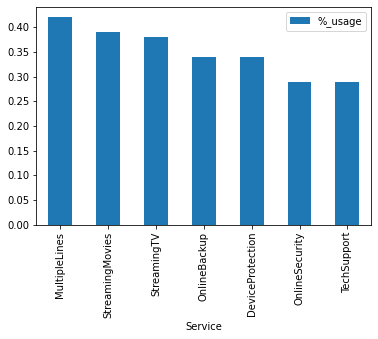

In [ ]:
service_usage.sort_values(by='%_usage', ascending=False).plot(x='Service', y='%_usage', kind='bar');

**Саммари по услугам**: Услугами телефонии пользуются 90% клиентов, интернетом 78%. Больше интернет пользователей на оптоволокне. 

Наиболее популярные услуги среди всех пользователей: многоканальная телефония (42%), стриминг кино (39%) и тв (38%), далее DeviceProtection и OnlineBackup (34%). Наименее популярные услуги: онлайн безопасность и техническая поддержка, ими пользуются 29% клиентов 

**Временные признаки: BeginDate, EndDate**: данные в базе представлены за период с октября 2013 по февраль 2010. При этом первые ушедшие клиенты появились только в июне 2014 года, спустя 9 месяцев после начала ведения базы. Это продолжительное время. Возможно факты ухода стали фиксироваться в базе не сразу. Также привлекает внимание всплеск пришедших пользователей в феврале 2014 года, который может также говорить о массовом занесении пользователей за предыдущие месяцы в базу "задним числом".

С конца 2014 по 2018 год пополнение клиентской базы каждый месяц было достаточно равномерным, после число новых пользователей начало расти, достигая максимума в 4ом квартале 2019 и январе 2020. Отток клиентов имеет восходящий тренд на всем рассматриваемом периоде, хотя в абсолютных цифрах он не велик.

Дополним базу признаками: месяц ухода, чтобы посмотреть ли сезонный тренд и в какие месяцы пользователи уходили активнее всего. 

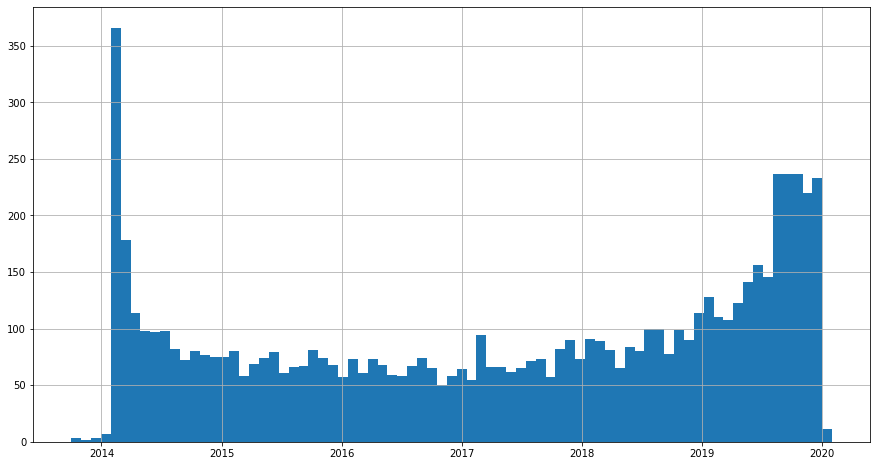

In [ ]:
# выведем распределение по датам прихода клиетов
df_contract['BeginDate'].hist(bins=77, figsize=(15,8));

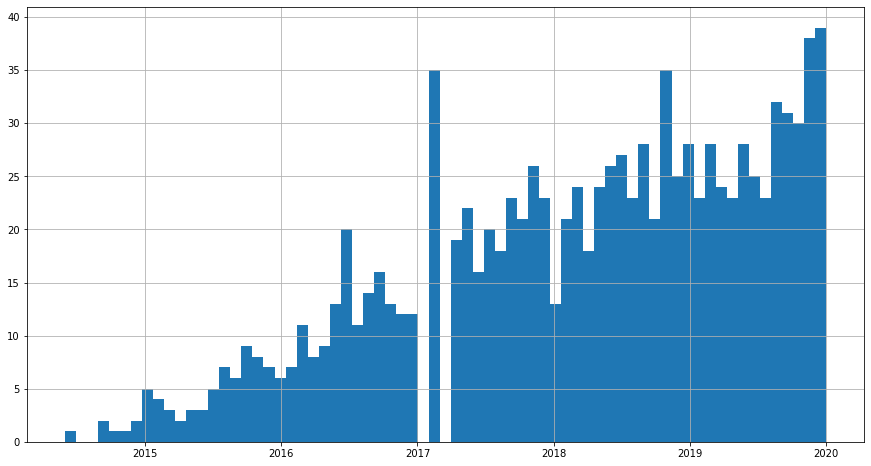

In [ ]:
#уберем из вывода последнюю дату (выгрузки), которую приписали всем оставшимся клиентам
df_contract[df_contract['EndDate'] !='2020-02-01']['EndDate'].hist(bins=69, figsize=(15,8));

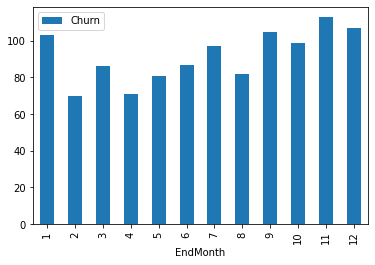

In [ ]:
# добавим столбец месяц окончания контракта
df['EndMonth'] = df['EndDate'].dt.month

end = df[df['Churn']==1].pivot_table(index='EndMonth', values='Churn', aggfunc=('sum'))
end.plot(kind='bar');

Недовольство пользователей нарастает ближе к концу года: больше всего клиентов уходило с сентября по декабрь и в январе.

**Duration (длительность обслуживания контракта)**: минимальное значение 0, т.е. в базе есть ползователи со сроком обсулуживания меньше месяца (таких всего 11, это те же пользователи, пришедшие в феврале 2020, когда была сделана выгрузка), максимальное - более 6 лет. Медианное значение - 761 день (~ 2,1 года), в то время как среднее 898 дней (~ 2,8 года) за счет довольно большой лояльной группы клиентов, которые обслуживаются более 6 лет.

In [ ]:
# посмотрим на распределение
df['Duration'].describe()

count    7043.000000
mean      898.555729
std       683.130510
min         0.000000
25%       276.000000
50%       761.000000
75%      1461.000000
max      2314.000000
Name: Duration, dtype: float64

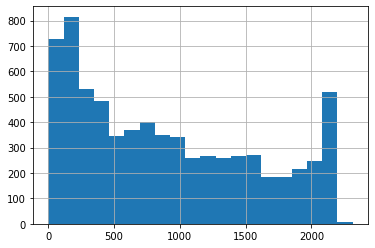

In [ ]:
df['Duration'].hist(bins=20);

### Исследование дисбаланса классов

In [ ]:
# посчитаем какую долю составляет класс 1, ушедшие клиенты
display(df[df['Churn']==1]['Churn'].sum(), round(df[df['Churn']==1]['Churn'].sum()/df.shape[0] *100, 2))

1101

15.63

Ушедшие клиенты составляют 15,6% от общего числа, всего в датасете их 1101. Наблюдается дисбаланс классов, что необходимо учесть на этапе построения моделей. Также датасет сам по себе небольшой всего 7000 наблюдений, это может сказаться на точности предсказаний.

Разделим все данные на ушедших и неушедших клиентов и сравним распределение признаков.
В нашем распоряжении 15 категориальных и 3 количественных признака.

Начнем сравнение по классам с категориальных признаков.

In [ ]:
# создадим список с названием категориальных переменных
cat_feat = list(df.columns[3:-1])
del cat_feat[3:7]
cat_feat

['Type',
 'PaperlessBilling',
 'PaymentMethod',
 'gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'MultipleLines',
 'Phone']

In [ ]:
# пройдем цикл по категориальным переменным и оценим разницу между распределением значений по ушедшим и оставшимся клиентам
for c_f in cat_feat:
    display(c_f,
           round((df.loc[df['Churn']==1].groupby(c_f)['Churn'].count()/df.loc[df['Churn']==1]['Churn'].count())/\
(df.loc[df['Churn']==0].groupby(c_f)['Churn'].count()/df.loc[df['Churn']==0]['Churn'].count())-1, 2))

'Type'

Type
Month-to-month   -0.37
One year          0.46
Two year          0.56
Name: Churn, dtype: float64

'PaperlessBilling'

PaperlessBilling
No    -0.18
Yes    0.13
Name: Churn, dtype: float64

'PaymentMethod'

PaymentMethod
Bank transfer (automatic)    0.39
Credit card (automatic)      0.42
Electronic check            -0.06
Mailed check                -0.58
Name: Churn, dtype: float64

'gender'

gender
Female   -0.04
Male      0.04
Name: Churn, dtype: float64

'SeniorCitizen'

SeniorCitizen
0   -0.07
1    0.38
Name: Churn, dtype: float64

'Partner'

Partner
No    -0.37
Yes    0.45
Name: Churn, dtype: float64

'Dependents'

Dependents
No    -0.06
Yes    0.14
Name: Churn, dtype: float64

'InternetService'

InternetService
DSL           -0.10
Fiber optic    0.28
No            -0.37
Name: Churn, dtype: float64

'OnlineSecurity'

OnlineSecurity
No    -0.15
Yes    0.40
Name: Churn, dtype: float64

'OnlineBackup'

OnlineBackup
No    -0.28
Yes    0.62
Name: Churn, dtype: float64

'DeviceProtection'

DeviceProtection
No    -0.27
Yes    0.59
Name: Churn, dtype: float64

'TechSupport'

TechSupport
No    -0.12
Yes    0.30
Name: Churn, dtype: float64

'StreamingTV'

StreamingTV
No    -0.27
Yes    0.48
Name: Churn, dtype: float64

'StreamingMovies'

StreamingMovies
No    -0.30
Yes    0.54
Name: Churn, dtype: float64

'MultipleLines'

MultipleLines
No    -0.37
Yes    0.60
Name: Churn, dtype: float64

'Phone'

Phone
No    -0.04
Yes    0.00
Name: Churn, dtype: float64

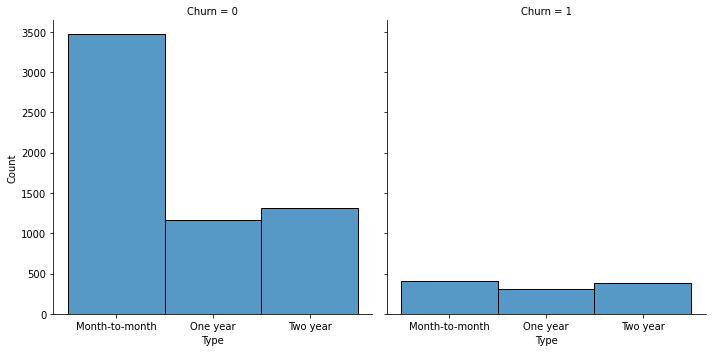

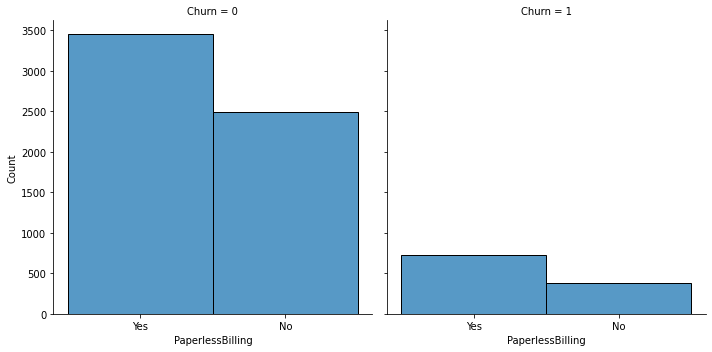

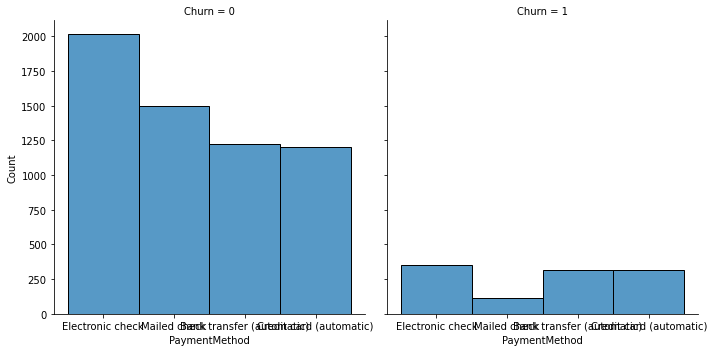

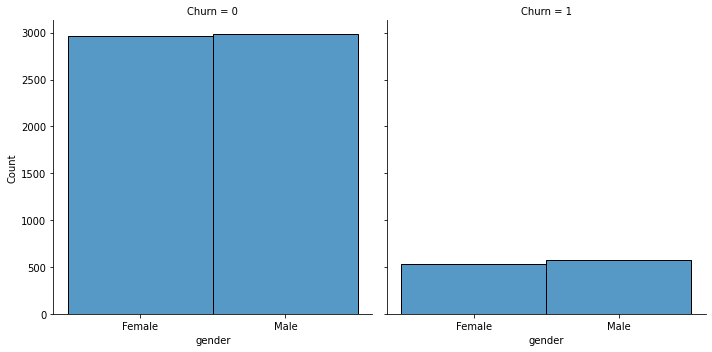

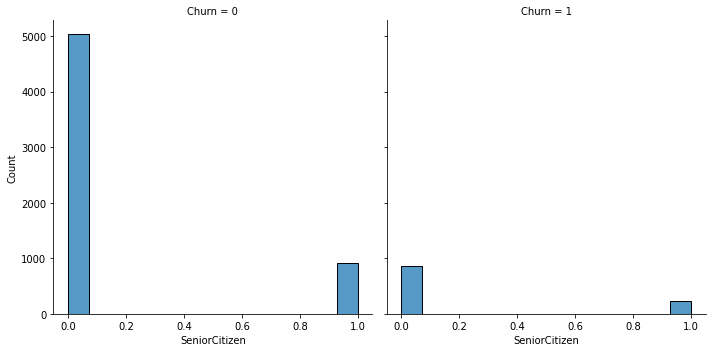

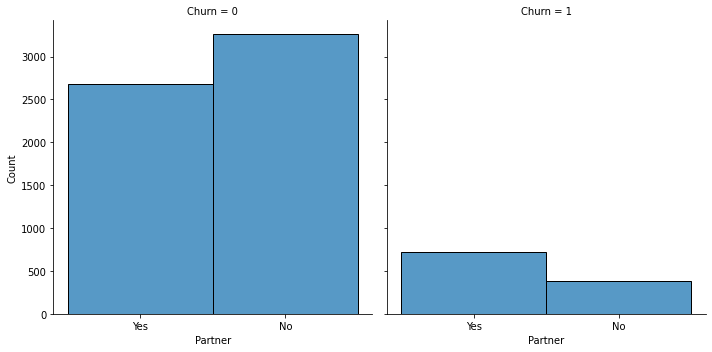

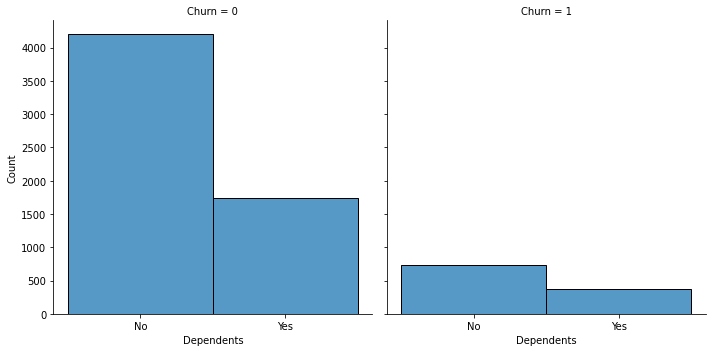

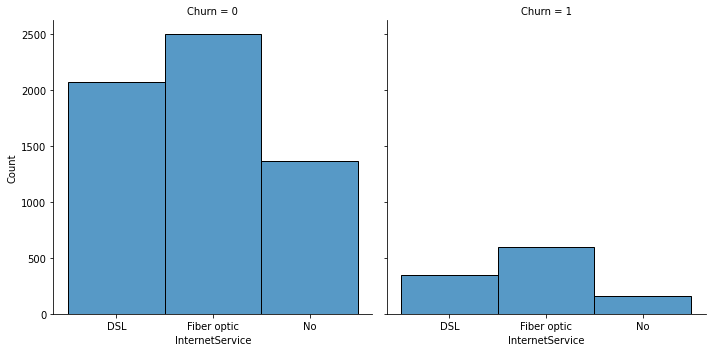

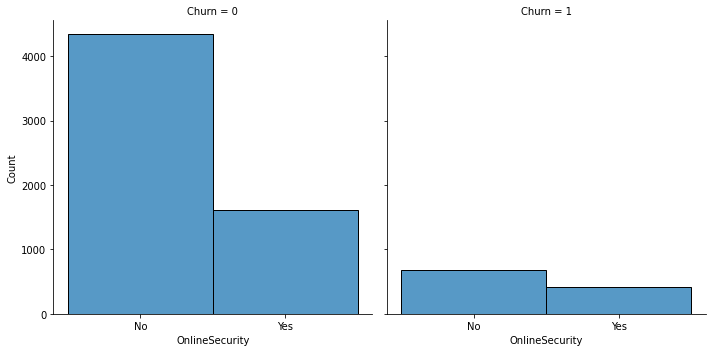

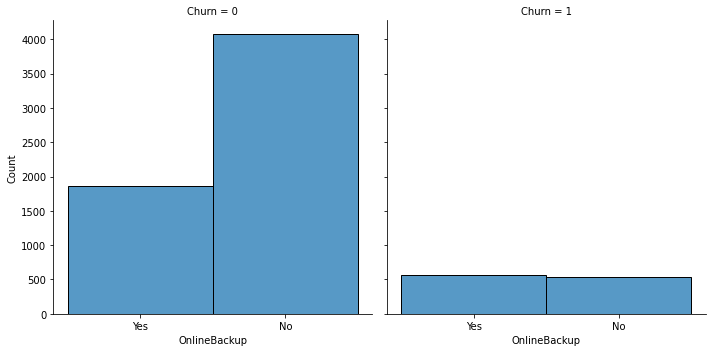

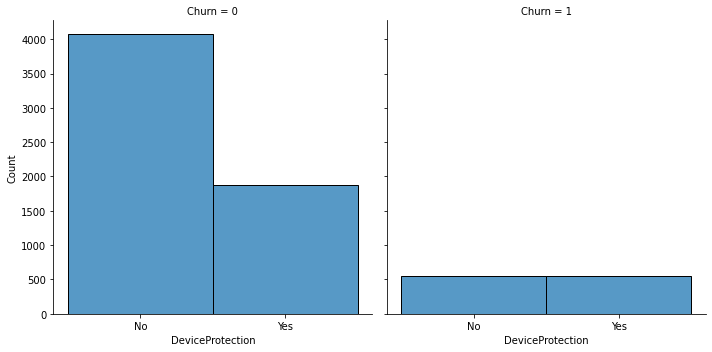

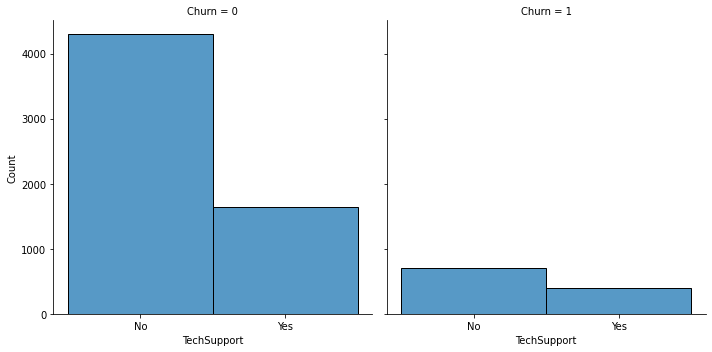

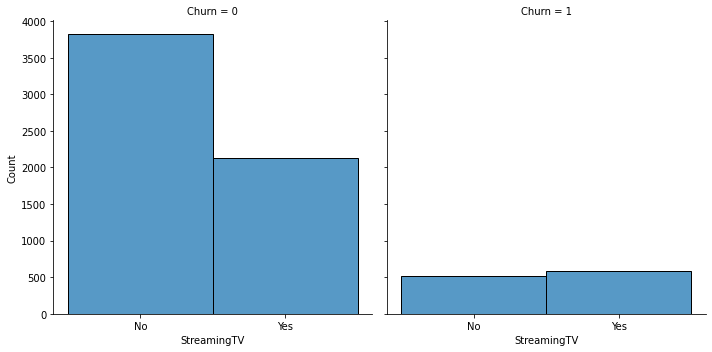

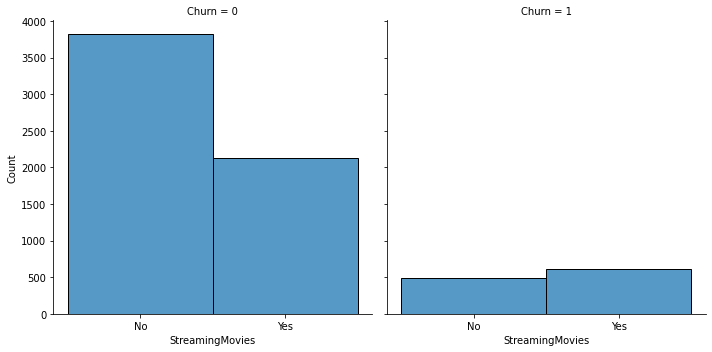

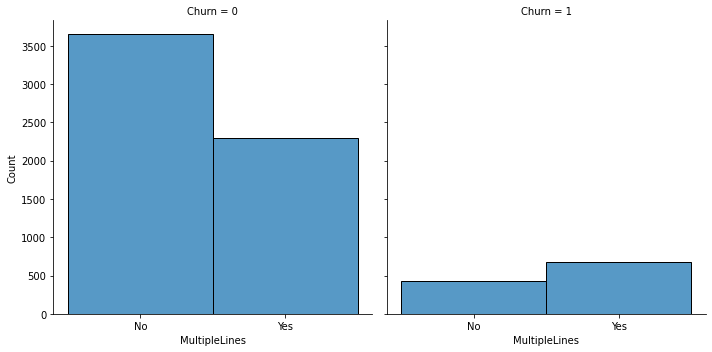

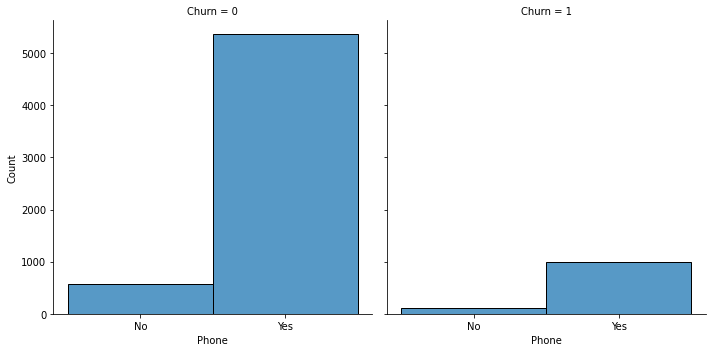

In [ ]:
for c_f in cat_feat:
    sns.displot(df, x=c_f, col='Churn')

- Тип платежа. Для ушедших клиентов было более свойственно пользоваться разовыми платежаи за длительный период (один год +46%, два года +56%), нежели помесячной оплатой (таких меньше на 37%). Оплаты на длительный период более выгодны компании, так как обеспечивают больший горизонт финансового планирования
- Безналичный расчет. Ушедшие на 13% больше пользовались безналичными платежами, что также предпочтительнее для компании
- Метод оплаты. Среди ушедших значительно более востребованы автоматические списания средств (+39% к банковскому трансферу и +42% к кредитной карте) и невостребованы оплаты по почте (-58%). Автоматические платежи снимают риск неоплаты не только для пользователя, но и обеспечивают более надежное поступление средств для компании. 


- Пол. Различия небольшие, среди ушедших всего на 4% больше мужчин
- Пенсионный возраст. Среди ушедших выше % пенсионеров (+38%)
- Брак. Среди ушедших выше % состоящих в браке (+45%)
- Иждивенцы. Среди ушедших немного выше % с иждивенцами (+14%) относительно оставшихся


- Интернет. Среди ушедших на 37% меньше тех, кто не пользуется Интернетом. И более популярно использование оптоволокна (более современное и технологичное по сравнению с можемным DSL)
- Ушедшие на 40% больше пользовались услугами OnlineSecurity, на 62% OnlineBackup, на 59% DeviceProtection, на 30% Тех поддержкой, на 48% стримингом ТВ и на 54% стримингом кино.
- Телефония. Разницы в использовании телефонии почти нет, но ушедшие на 60% больше пользовались услугой паралелльных линий.

**Вывод**: Предварительная картина вырисовывается неутешительной, в целом портрет ушедшего пользователя оказывается более привлекательным для бизнеса, чем оставшихся: компания в большей степени теряет более активных потребителей сервисов и услуг. И с точки зрения финансовой надежности, ушедшие клиенты в среднем обладали более привлекательным "поведением", чем оставшиеся (в основной массе). От уходов таких клиентов потери компании выше. Это подчеркивает важность предсказния ухода клиента, основнанного на имеющейся базе

Сравним классы по количественным признакам: MonthlyCharges, TotalCharges, Duration

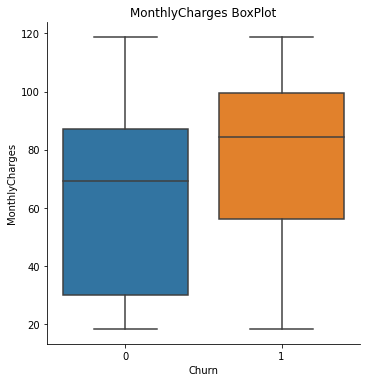

In [ ]:
sns.catplot(data=df, x='Churn', y='MonthlyCharges', kind='box');
plt.title('MonthlyCharges BoxPlot');

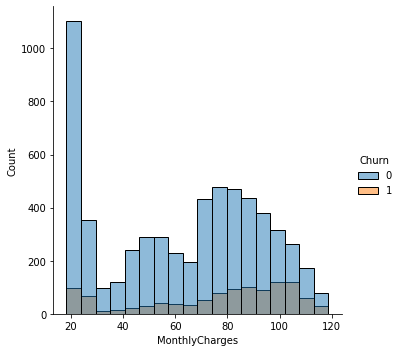

In [ ]:
sns.displot(df, x='MonthlyCharges', hue='Churn');

MonthlyCharges: Медианный средний платеж для ушедшего клиента выше, распределение скошенно вправо, (84 против 69). Среди ушедших существенно меньше клиентов с минимальным объемом платежа.

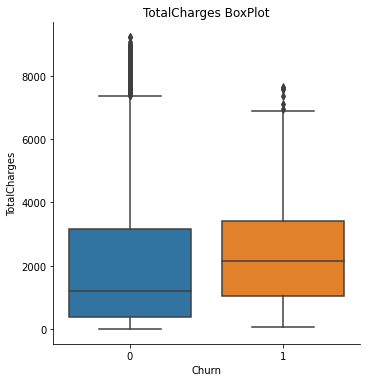

In [ ]:
sns.catplot(data=df, x='Churn', y='TotalCharges', kind='box');
plt.title('TotalCharges BoxPlot');

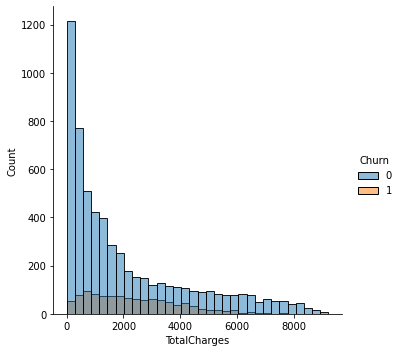

In [ ]:
sns.displot(df, x='TotalCharges', hue='Churn');

In [ ]:
# посчитаем долю сверх доходных клиентов для обоих классов
display(df.loc[(df['TotalCharges']>7000) & (df['Churn']==0)]['customerID'].count(), 
        df.loc[(df['TotalCharges']>7000) & (df['Churn']==1)]['customerID'].count())

278

5

**TotalCharges**: медианный размер общих расходов выше для ушедших клиентов 2139 - против 1192, среднее значение также выше у ушедших. Распределение общих расходов среди оставшихся клиентов имеет выраженный экспоненциальный характер и скошена влево с большим числом клиентов небольшим общим чеком. Ушедшие более равномерно распределны по шкале TotalCharges, с постепенным уменьшением объема клиента после 3000.
Среди ушедших было также 5 клиентов с аномально высокими расходами (>7000), однако доля их среди ушедших ниже, чем среди оставшихся (5 против 278, т.е. менее 2%, в то время как ушло 15% клиентов).

**Duration (срок обслуживания)**: 
- у ушедших средний и медианный сроки обсулуживания выше на 3% и 30% соответственно. 
- Распределение по оставшимся скошенно влево, с потсепенным уменьшеним объема клиентов при росте длительности обслуживания, но есть счастливые для компнаии исключения: довольно большая по объему группа сверх лояльных клиентов, которая обслуживается более 5,5 лет. Среднее значение существенно выше медианного.
- Для ушедших распределение похоже на нормальное, среднее и медианные значения близки (~2,5 года). 
- Размах для оставшихся выше, а значит самые "старые" клиенты еще с кампанией.

In [ ]:
df.loc[(df['Churn']==1)]['Duration'].describe()

count    1101.000000
mean      924.863760
std       458.771309
min        28.000000
25%       577.000000
50%       915.000000
75%      1249.000000
max      2129.000000
Name: Duration, dtype: float64

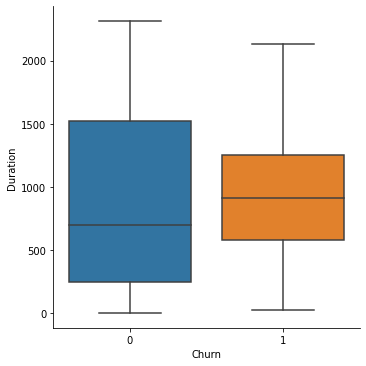

In [ ]:
sns.catplot(data=df, x='Churn', y='Duration', kind='box');

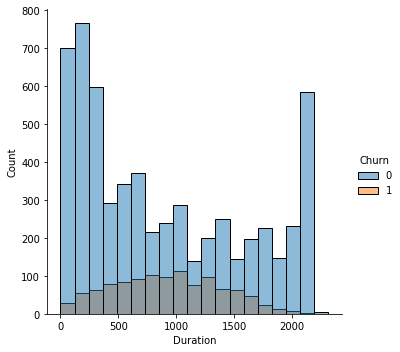

In [ ]:
sns.displot(df, x='Duration', hue='Churn');

### Проверка на корреляцию

In [ ]:
# избавимся от лишних признаков
df_for_corr = df.drop(['customerID', 'BeginDate', 'EndDate', 'EndMonth'], axis=1)
df_for_corr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              7043 non-null   object 
 1   PaperlessBilling  7043 non-null   object 
 2   PaymentMethod     7043 non-null   object 
 3   MonthlyCharges    7043 non-null   float64
 4   TotalCharges      7043 non-null   float64
 5   Churn             7043 non-null   int64  
 6   Duration          7043 non-null   int64  
 7   gender            7043 non-null   object 
 8   SeniorCitizen     7043 non-null   int64  
 9   Partner           7043 non-null   object 
 10  Dependents        7043 non-null   object 
 11  InternetService   7043 non-null   object 
 12  OnlineSecurity    7043 non-null   object 
 13  OnlineBackup      7043 non-null   object 
 14  DeviceProtection  7043 non-null   object 
 15  TechSupport       7043 non-null   object 
 16  StreamingTV       7043 non-null   object 


In [ ]:
# функция для выделения высоких значений
def highlight(x, color):
    return np.where((x >=0.7) & (x < 1), f"color: {color};", None)

df_for_corr[['MonthlyCharges', 'TotalCharges', 'Duration']].corr().style.apply(highlight, color='blue', axis=1)

Как уже отмечали выше между общими расходами и продолжительностью наблюдается сильная корреляция, и средняя с расходами за месяц. Посчитаем корреляцию между всеми признаками с помощью phik корреляции, указав количественные признаки

In [ ]:
phik_overview = df_for_corr.phik_matrix(interval_cols=['MonthlyCharges', 'TotalCharges', 'Duration'])
phik_overview.round(2)

# выделим признаки с сильной корреляцией
phik_overview.style.apply(highlight, color='blue', axis=1)

In [ ]:
# выделим среднюю корреляцию
def highlight(x, color):
    return np.where((x >=0.5) & (x < 0.7), f"color: {color};", None)

phik_overview.style.apply(highlight, color='orange', axis=1)

- Самая сильная корреляция целевого признака Churn наблюдается c продолжительностью (0.37), т.е. чем дольше клиент обслуживается, тем вероятнее он скоро уйдет, но связь по силе ниже среднего.
- Плата за месяц в большей степени определяется пользованием интернетом, стримингами и телефоном (сильная корреляция 0.83-0.91), оставшийся набор услуг - средняя по силе корреляция (0.55-0.67)
- Между стримингом тв и кино сильная корреляция, кто пользуется одним с большой вероятностью пользуется и другим (0.74).
- Наибольшее влияние на продолжительность договора имеет тип оплаты, а значит этот признак важен и для предсказания оттока.
- В свою очередь на тип оплаты влияет значение признакак InternetService
- Признаки брака и иждивенцов имеют среднюю корреляцию (0.65), определяя семейный статус клиента.
- Подключенные услуги интернета взаимно влияют друг на друга: онлайн безопасность коррелирует с технической поддержкой (0.5), защита устройств со стримингом (0.58)

На основе коэффицентов корреляции уберем ряд признаков из данных для построения моделей:
- TotalCharges. Среди количественных переменных TotalCharges коррелирует с длительностью обсулуживания Duration и платой за месяц Month с коэффициентами >0.7
- Gender. Корреляция с Churn по phik очень низкая. Аналогично при исследовании признаков по классам, разницы не было.
- Phone. Корреляция с Churn по phik нулевая. Аналогично при исследовании признаков по классам, разницы не было.

### Кластеризация

Разброс по длительности обслуживания и размеру месячной платы значителен. Размер месячной платы определяется набором услуг, включенных в контракт пользователя.
Для удержания клиентов важно понимать на какие сегменты делятся пользователи, в том числе в какие сегменты попадают уходящие клиенты.

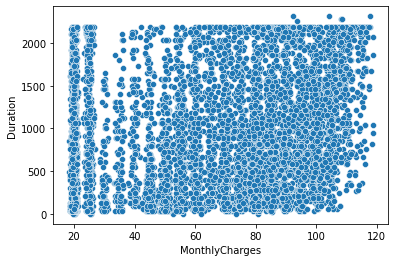

In [ ]:
#построим диаграмму рассеяния для всех клиентов телекома
sns.scatterplot(data=df, x='MonthlyCharges', y='Duration'); #, hue="time")

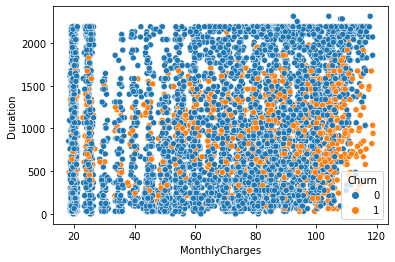

In [ ]:
#построим диаграмму рассеяния и отметим уушедших
sns.scatterplot(data=df, x='MonthlyCharges', y='Duration', hue='Churn');

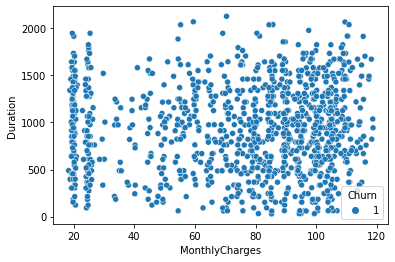

In [ ]:
#построим диаграмму рассеяния только для ушедших
sns.scatterplot(data=df.loc[df['Churn']==1], x='MonthlyCharges', y='Duration', hue='Churn');

В целом клиенты достаточно равномерно заполнили всю область. Визуально сегменты неразличимы, для такого распределения не подойдет метод К-средних для кластеризации.

Однако выделяются определенные закономерности: 
- более строгие градации ценообразования для меньших размеров оплаты (клиенты платят условные 20-25-30-35-40 единиц), после 40 размер оплаты очень сильно варьируется 
- для размеров оплаты между 30 и 40 мало клиентов с обслуживанием более 1500 дней (~ 4,1 Года)
- "пустой" правый нижний угол: мало относительно новых клиентов с максимальным объемом оплат (>110). 
- самые старые клиенты находятся в группе более высоких плат за месяц
- Среди ушедших клиентов выделяется сегмент с минимальными платами за месяц, которые уходили достаточно равномерно по всем срокам обслуживания. Клиентов с размером платы от 25 до примерно 70 меньше среди уходящих (на 28%). Клиенты с оплатой более 70 реже уходят до года. 
- Клиенты реже уходят после 1750 дней обслуживания (~ 4,8 лет), независимо от размера платы

In [ ]:
display('% клиентов с оплатой 25-70 среди всех', df.loc[(df['MonthlyCharges']>25) & (df['MonthlyCharges']<70)]['customerID'].count()/df.shape[0])
display('% клиентов с оплатой 25-70 среди ушедших', df.loc[(df['Churn']==1) & (df['MonthlyCharges']>25) & (df['MonthlyCharges']<70)]['customerID'].count()/df.loc[df['Churn']==1].shape[0])

'% клиентов с оплатой 25-70 среди всех'

0.29050120687207154

'% клиентов с оплатой 25-70 среди ушедших'

0.2125340599455041

Далее последовательно добавим категориальные признаки на диаграмму рассеяния

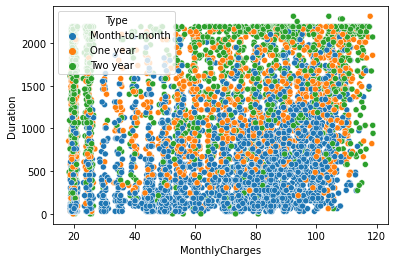

In [ ]:
#построим диаграмму рассеяния
sns.scatterplot(data=df, x='MonthlyCharges', y='Duration', hue='Type');

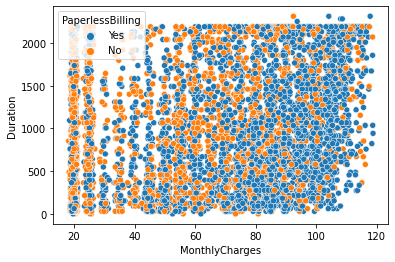

In [ ]:
#построим диаграмму рассеяния
sns.scatterplot(data=df, x='MonthlyCharges', y='Duration', hue='PaperlessBilling');

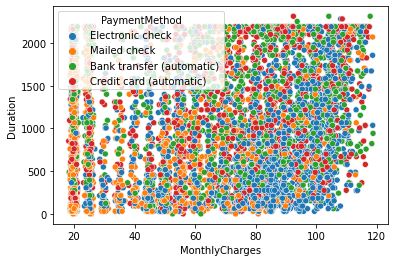

In [ ]:
#построим диаграмму рассеяния
sns.scatterplot(data=df, x='MonthlyCharges', y='Duration', hue='PaymentMethod');

- **Тип платежа**. Новые клиенты (первый год обслуживания) платят в основном от месяца к месяцу. Чем дольше клиент с компанией, тем выше платежей за год и два (особенно после 3х лет обслуживания). Также для размера платы выше 105 наблюдается скопление годовых и дву-годовых платежей. В целом, чем дольше человек с компанией и чем больше его плата, тем вероятнее, что он будет оплачивать услуги вперед (One Year, Two Year). Исключение клиенты, кластеризирующиеся вокруг минимальных объемов плат 20-25, там также растет число оплат вперед после 3х лет.
- **Безналичный расчет**. После размера помесячной оплаты >80 резко увеличивается доля безналичных расчетов.
- **Метод оплаты**. Клиенты достаточно равномерно и хаотически распределены по разным способам оплаты. Оплата почтой в большей степени характерна для размера платы до 80.

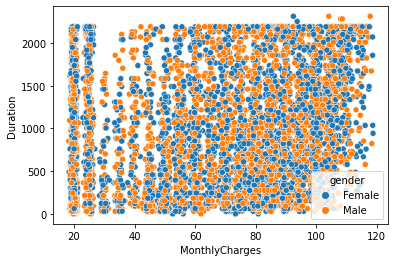

In [ ]:
#построим диаграмму рассеяния
sns.scatterplot(data=df, x='MonthlyCharges', y='Duration', hue='gender');

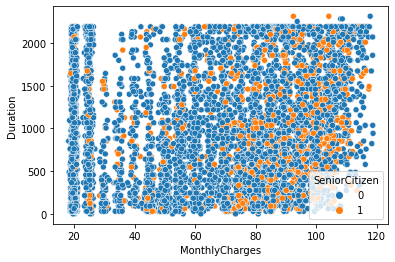

In [ ]:
#построим диаграмму рассеяния
sns.scatterplot(data=df, x='MonthlyCharges', y='Duration', hue='SeniorCitizen');

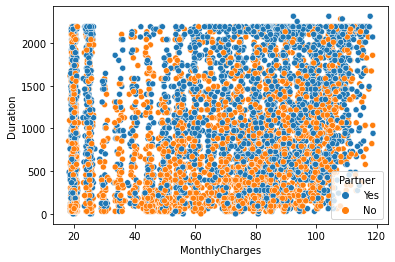

In [ ]:
#построим диаграмму рассеяния
sns.scatterplot(data=df, x='MonthlyCharges', y='Duration', hue='Partner');

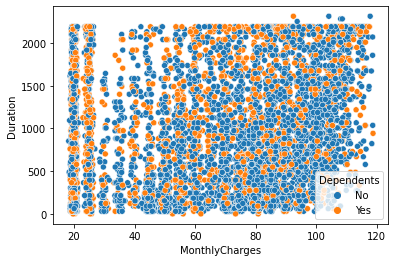

In [ ]:
sns.scatterplot(data=df, x='MonthlyCharges', y='Duration', hue='Dependents');

- **Пол**. Равномерно хаотично распределены мужчины и женщины.
- **Пенсионеры**. Заметно скопление пенсионеров для объема платы за месяц более 70 и очень небольшое число платит минимальную ставку в 20 (эффективные кросс-продажи для не самой продвинутой интернет аудитории?). Распределение по длительности обслуживания равномерное.
- **Брак**. Распределение по размеру платы равномерное, по длительности - чем дольше клиент с кампанией тем чаще встречаются семейные.
- **Иждивенцы**. В нижнем правый угол (оплата более 80 и срок обслуживания меньше 4 лет) скопление клиентов без иждивенцев больше. Т.е. основная масса самого доходного сегмента с небольшим и средним сроком обслуживания - бездетные (и тратят свободные деньги в том числе на услуги телеком)

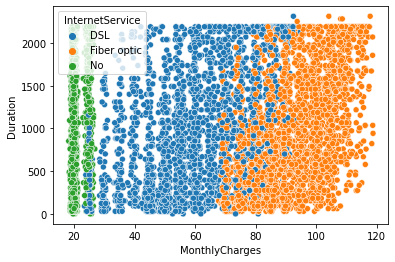

In [ ]:
#построим диаграмму рассеяния
sns.scatterplot(data=df, x='MonthlyCharges', y='Duration', hue='InternetService');

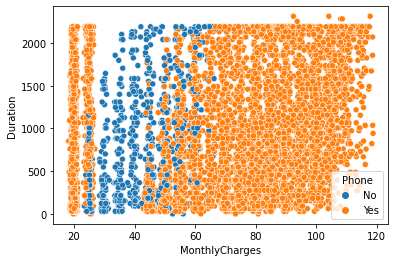

In [ ]:
#построим диаграмму рассеяния
sns.scatterplot(data=df, x='MonthlyCharges', y='Duration', hue='Phone');

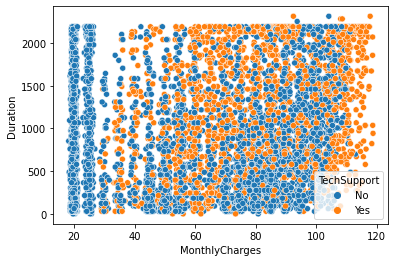

In [ ]:
#построим диаграмму рассеяния
sns.scatterplot(data=df, x='MonthlyCharges', y='Duration', hue='TechSupport');

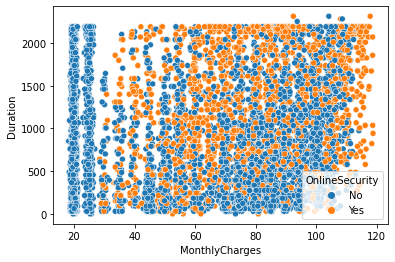

In [ ]:
#построим диаграмму рассеяния
sns.scatterplot(data=df, x='MonthlyCharges', y='Duration', hue='OnlineSecurity');

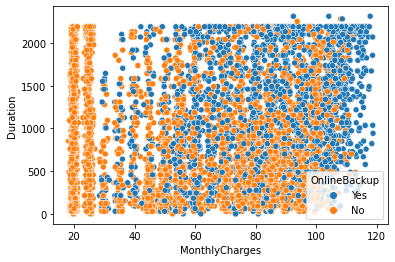

In [ ]:
#построим диаграмму рассеяния
sns.scatterplot(data=df, x='MonthlyCharges', y='Duration', hue='OnlineBackup');

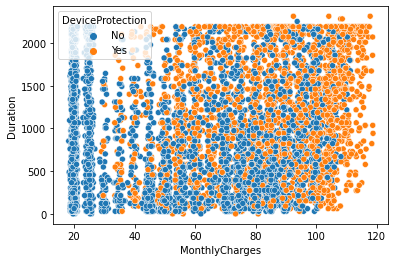

In [ ]:
#построим диаграмму рассеяния
sns.scatterplot(data=df, x='MonthlyCharges', y='Duration', hue='DeviceProtection');

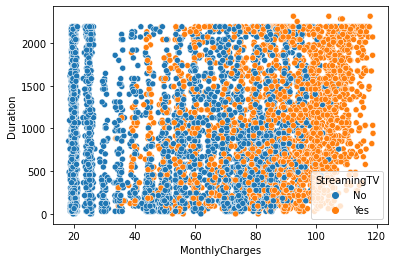

In [ ]:
#построим диаграмму рассеяния
sns.scatterplot(data=df, x='MonthlyCharges', y='Duration', hue='StreamingTV');

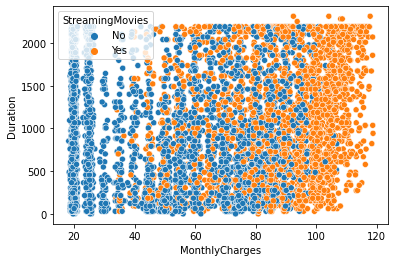

In [ ]:
#построим диаграмму рассеянияв
sns.scatterplot(data=df, x='MonthlyCharges', y='Duration', hue='StreamingMovies');

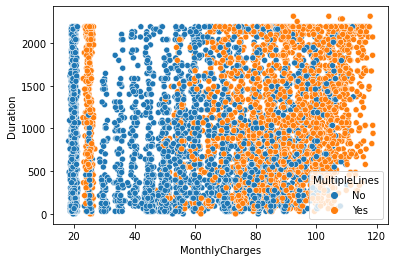

In [ ]:
#построим диаграмму рассеяния
sns.scatterplot(data=df, x='MonthlyCharges', y='Duration', hue='MultipleLines');

- **Пользование интернетом**. Достаточно четкое разделение на кластеры по признаку InternetService: минимальные оплаты 20-25 минимум интернет пользователей, оплата 30-70 пользователи модемных соединений, оплата более 70 (и 80 для клиентов после трех лет обслуживания) - оптоволокно
- **Пользователи телефонией**. Те, кто пользуются услугами телефонии, делятся на два лагеря: минимальные оплаты и оплаты более 60. В промежутке между 30-40 у.е. за месяц находятся только интернет-юзеры. 

- **Тех обслуживание, Онлайн безопасность**. Наибольшие скопления пользователей этой услуги для оплат в диапазоне 60-70 и более 100
- **Услуга OnlineBackup**. Заметно, что пользование услугой смещено относительно остальной группы примерно на 15-20 единиц вправо, вероятно настолько увеличивает оплату подключение услуги. После трех лет обслуживания услуга становится популярнее, все больше пользователей прибегают к ней.
- **Защита устройств**. Скопление тяготеет вправо (высокие помесячные оплаты) и вверх (длительный срок обслуживания).
- **Стриминг ТВ и Кино**. Основное скопление для клиентов с оплатой >95 за меcяц
- **Многоканальная телефония**. Выделяются два кластера: скопление вокруг невысокой оплаты 30 за месяц (возможно единственная услуга, так в этой группе почти нет интернет юзеров, клиенты лояльны - их больше с ростом срока обслуживания) и второе - большое скопление точек после 60 уе равномерно распределенных по всему времени обслуживания.

In [ ]:
# для дальнейшей работы с данными сделаем копию датасета
k_data = df[['customerID','Type','PaperlessBilling','PaymentMethod','MonthlyCharges', 'Duration', 'gender', 'SeniorCitizen',
             'Partner', 'Dependents', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
             'TechSupport', 'StreamingTV', 'StreamingMovies', 'Phone', 'MultipleLines','Churn']]
k_data.shape

(7043, 20)

In [ ]:
# создадим отдельный признак: пользуются только Интернетом, только Телефоном, обоими типами услуг  
k_data['customer'] = 0
k_data.loc[(k_data['InternetService']!='No') & (k_data['Phone']=='No'), 'customer'] = 'internet_user'
k_data.loc[(k_data['InternetService']=='No') & (k_data['Phone']!='No'), 'customer'] = 'phone_user'
k_data.loc[(k_data['InternetService']!='No') & (k_data['Phone']!='No'), 'customer'] = 'total_user'

round(k_data.groupby('customer')['Type'].count()/k_data.shape[0], 2)

/tmp/ipykernel_858/3038059000.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  k_data['customer'] = 0
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


customer
internet_user    0.10
phone_user       0.22
total_user       0.69
Name: Type, dtype: float64

70% клиентов пользуются обоими типами услуг, пользователи исключительно телефонии занимают 22% аудитории, только интернета - 10%

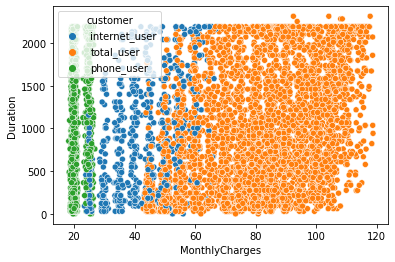

In [ ]:
#построим диаграмму рассеяния
sns.scatterplot(data=k_data, x='MonthlyCharges', y='Duration', hue='customer');

Диаграмма очень похожа на рассеяние по признаку InternetService: пользователи только Интернета в основной массе пользуются DSL соединеним

In [ ]:
# добавим признак число используемых услуг
k_data['num_serv'] = 0
services=['OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies', 'Phone','MultipleLines']

for serv in services:
    k_data.loc[k_data[serv]=='Yes', serv] = 1
    k_data.loc[k_data[serv]=='No', serv] = 0

    
k_data['num_serv'] = (k_data['OnlineSecurity']+
                      k_data['OnlineBackup']+
                      k_data['DeviceProtection']+
                      k_data['TechSupport']+
                      k_data['StreamingTV']+
                      k_data['StreamingMovies']+
                      k_data['Phone']+
                      k_data['MultipleLines'])

k_data['num_serv'] = k_data['num_serv'].astype(int)

round(k_data.groupby('num_serv')['Type'].count()/k_data.shape[0], 2)

/tmp/ipykernel_858/3412617166.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  k_data['num_serv'] = 0
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/tmp/ipykernel_858/3412617166.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.or

num_serv
0    0.01
1    0.24
2    0.17
3    0.14
4    0.13
5    0.13
6    0.10
7    0.06
8    0.03
Name: Type, dtype: float64

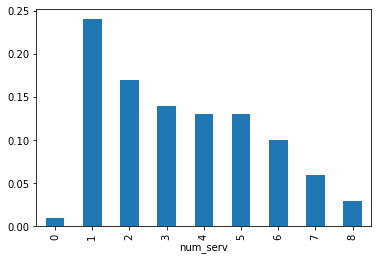

In [ ]:
round(k_data.groupby('num_serv')['Type'].count()/k_data.shape[0], 2).plot(kind='bar');

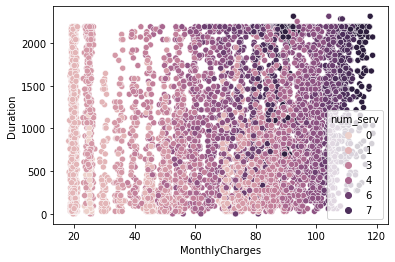

In [ ]:
#построим диаграмму рассеяния
sns.scatterplot(data=k_data, x='MonthlyCharges', y='Duration', hue='num_serv');

In [ ]:
k_data['MonthlyCharges'].corr(k_data['num_serv'])

0.8023224193771193

24% клиентов пользуются только одной услугой. Основная масса пользуется набором из 2-5 услуг (57%). Около 20% клиентов пользуется 6+ услугами. Также в базе есть 1% "спящих" пользователей, для которых все услуги проставлены 'No'. В целом заметна корреляция роста оплаты с ростом объема услуг, однако в области между 70 и 90 наблюдается скопление пользователей с меньшим набором услуг для срока до 3 лет и с большим набором услуг для более длительного срока (возможно компания около трех лет назад изменила условия для новых клиентов, например урезав пакет услуг, оставив условия прежними для старых клиентов).

In [ ]:
# создадим столбец с детализацией услуги для моно-пользователей
k_data['single_serv'] = 'No' 

for serv in services:
    k_data.loc[(k_data['num_serv']==1) & (k_data[serv]==1),'single_serv'] = serv
    
k_data.head()    

/tmp/ipykernel_858/1230237789.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  k_data['single_serv'] = 'No'
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

customerID            Type PaperlessBilling              PaymentMethod  \
0  7590-VHVEG  Month-to-month              Yes           Electronic check   
1  5575-GNVDE        One year               No               Mailed check   
2  3668-QPYBK  Month-to-month              Yes               Mailed check   
3  7795-CFOCW        One year               No  Bank transfer (automatic)   
4  9237-HQITU  Month-to-month              Yes           Electronic check   

   MonthlyCharges  Duration  gender  SeniorCitizen Partner Dependents  ...  \
0           29.85        31  Female              0     Yes         No  ...   
1           56.95      1036    Male              0      No         No  ...   
2           53.85       123    Male              0      No         No  ...   
3           42.30      1371    Male              0      No         No  ...   
4           70.70       153  Female              0      No         No  ...   

  DeviceProtection TechSupport StreamingTV StreamingMovies Phone  \
0                0           0           0               0     0   
1                1           0           0               0     1   
2                0           0           0               0     1   
3                1           1           0               0     0   
4                0           0           0               0     1   

  MultipleLines Churn       customer num_serv   single_serv  
0             0     0  internet_user        1  OnlineBackup  
1             0     0     total_user        3            No  
2             0     0     total_user        3            No  
3             0     0  internet_user        3            No  
4             0     0     total_user        1         Phone  

[5 rows x 23 columns]

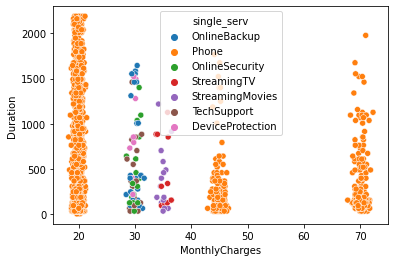

In [ ]:
#построим диаграмму рассеяния
sns.scatterplot(data=k_data.loc[k_data['single_serv']!='No'], x='MonthlyCharges', y='Duration', hue='single_serv');

- Среди монопользователей выделяются три группы: с минимальной оплатой в 20, с оплатой в 45 и оплатой в 70. Вероятно кроме многоканальности есть другие факторы, определяющие стоимость платы за телефонию.
- Пользователи OnlineBackup, OnlineSecurity, DeviceProtection, TechSupport платят 30, в основном это отнсоительно свежие клиенты (меньше трех лет обслуживания)
- Пользователи только Стримингов платят 35, наибольшее скопление до года

## Обучение моделей

### Подготовка данных для моделирования

Подготовим данные для моделирования:
- запишем целевой признак в target, а отобранные для построения моделей признаки - в features
- разделим выборки на обучающую и тестовую в пропорции 75\25
- промасштабируем количественные переменные
- закодируем категориальные переменные

In [ ]:
# избавимся от лишних признаков
features = df.drop(['customerID', 'BeginDate', 'EndDate', 'EndMonth', 'Churn', 'TotalCharges', 'gender', 'Phone'], axis=1)
target = df['Churn']

display(features.shape, target.shape)

(7043, 16)

(7043,)

In [ ]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              7043 non-null   object 
 1   PaperlessBilling  7043 non-null   object 
 2   PaymentMethod     7043 non-null   object 
 3   MonthlyCharges    7043 non-null   float64
 4   Duration          7043 non-null   int64  
 5   SeniorCitizen     7043 non-null   int64  
 6   Partner           7043 non-null   object 
 7   Dependents        7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  MultipleLines     7043 non-null   object 
dtypes: float64(1), int64(2), object(13)
memory

Разделили на признаки и целевой признак. Модели будут предсказывать уход, исходя из 14 категориальных и 2 количественных признаков

In [ ]:
#разделим на выборки обучающую и тестовую
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=80523, stratify=target)

display(features_train.shape , features_test.shape)

(5282, 16)

(1761, 16)

In [ ]:
# промасштабируем количественные признаки

numeric = ['MonthlyCharges', 'Duration']

warnings.filterwarnings('ignore')

scaler = StandardScaler()
scaler.fit(features_train[numeric])

features_train[numeric] = scaler.transform(features_train[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

pd.options.mode.chained_assignment = None

features_train.head()

Type PaperlessBilling            PaymentMethod  \
2122        One year              Yes             Mailed check   
5299  Month-to-month              Yes  Credit card (automatic)   
525         One year               No         Electronic check   
2099  Month-to-month              Yes  Credit card (automatic)   
3992        Two year               No             Mailed check   

      MonthlyCharges  Duration  SeniorCitizen Partner Dependents  \
2122        0.369892 -0.786476              0      No         No   
5299        1.212870 -0.024862              1     Yes         No   
525         0.879984  0.914658              0      No         No   
2099        0.469260  0.467688              0     Yes         No   
3992        0.663029  1.004346              0      No         No   

     InternetService OnlineSecurity OnlineBackup DeviceProtection TechSupport  \
2122             DSL             No           No               No         Yes   
5299     Fiber optic             No           No               No         Yes   
525      Fiber optic            Yes           No              Yes          No   
2099     Fiber optic             No           No               No         Yes   
3992             DSL            Yes          Yes              Yes          No   

     StreamingTV StreamingMovies MultipleLines  
2122         Yes             Yes           Yes  
5299         Yes             Yes           Yes  
525          Yes              No            No  
2099          No              No           Yes  
3992         Yes             Yes           Yes

In [ ]:
# обновим список категориальных переменных
del cat_feat[3]
del cat_feat [-1]
cat_feat

['Type',
 'PaperlessBilling',
 'PaymentMethod',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'MultipleLines']

In [ ]:
# закодируем категориальные переменные OHE
# обучим кодировщик на обучающей выборке
ohe = OneHotEncoder(drop = 'first').fit(features_train[cat_feat])

# обработаем обучающую выборку
feature_array_train = ohe.transform(features_train[cat_feat]).toarray()
features_train_ohe = pd.DataFrame(feature_array_train, columns= ohe.get_feature_names(cat_feat))
features_train_ohe

display(features_train_ohe.shape, features_train.shape)

features_train_ohe.index = features_train.index

features_train_ohe = pd.concat([features_train, features_train_ohe], axis=1)

features_train_ohe.shape

(5282, 18)

(5282, 16)

(5282, 34)

In [ ]:
# обработаем тестовую выборку OHE
feature_array_test = ohe.transform(features_test[cat_feat]).toarray()
features_test_ohe = pd.DataFrame(feature_array_test, columns= ohe.get_feature_names(cat_feat))

display(features_test_ohe.shape, features_test.shape)

features_test_ohe.index = features_test.index
features_test_ohe = pd.concat([features_test, features_test_ohe], axis=1)

(1761, 18)

(1761, 16)

In [ ]:
# избавимся от первоначальных незакодированных признаков
features_train_ohe = features_train_ohe.drop(cat_feat, axis=1)
features_test_ohe = features_test_ohe.drop(cat_feat, axis=1)

In [ ]:
display(features_train_ohe, features_test_ohe)

MonthlyCharges  Duration  Type_One year  Type_Two year  \
2122        0.369892 -0.786476            1.0            0.0   
5299        1.212870 -0.024862            0.0            0.0   
525         0.879984  0.914658            1.0            0.0   
2099        0.469260  0.467688            0.0            0.0   
3992        0.663029  1.004346            0.0            1.0   
...              ...       ...            ...            ...   
5893       -1.347531 -0.786476            0.0            1.0   
3611        1.158217  0.511797            0.0            1.0   
2731        1.443074  1.496896            0.0            0.0   
4159        0.830300  1.320460            0.0            0.0   
4465       -0.484679  0.066296            1.0            0.0   

      PaperlessBilling_Yes  PaymentMethod_Credit card (automatic)  \
2122                   1.0                                    0.0   
5299                   1.0                                    1.0   
525                    0.0                                    0.0   
2099                   1.0                                    1.0   
3992                   0.0                                    0.0   
...                    ...                                    ...   
5893                   1.0                                    0.0   
3611                   1.0                                    1.0   
2731                   0.0                                    1.0   
4159                   1.0                                    0.0   
4465                   1.0                                    0.0   

      PaymentMethod_Electronic check  PaymentMethod_Mailed check  \
2122                             0.0                         1.0   
5299                             0.0                         0.0   
525                              1.0                         0.0   
2099                             0.0                         0.0   
3992                             0.0                         1.0   
...                              ...                         ...   
5893                             0.0                         0.0   
3611                             0.0                         0.0   
2731                             0.0                         0.0   
4159                             1.0                         0.0   
4465                             1.0                         0.0   

      SeniorCitizen_1  Partner_Yes  Dependents_Yes  \
2122              0.0          0.0             0.0   
5299              1.0          1.0             0.0   
525               0.0          0.0             0.0   
2099              0.0          1.0             0.0   
3992              0.0          0.0             0.0   
...               ...          ...             ...   
5893              0.0          1.0             1.0   
3611              0.0          0.0             0.0   
2731              0.0          0.0             0.0   
4159              1.0          0.0             0.0   
4465              0.0          0.0             0.0   

      InternetService_Fiber optic  InternetService_No  OnlineSecurity_Yes  \
2122                          0.0                 0.0                 0.0   
5299                          1.0                 0.0                 0.0   
525                           1.0                 0.0                 1.0   
2099                          1.0                 0.0                 0.0   
3992                          0.0                 0.0                 1.0   
...                           ...                 ...                 ...   
5893                          0.0                 1.0                 0.0   
3611                          1.0                 0.0                 0.0   
2731                          1.0                 0.0                 1.0   
4159                          1.0                 0.0                 1.0   
4465                          0.0                 0.0                 0.0   

      OnlineBacku

MonthlyCharges  Duration  Type_One year  Type_Two year  \
908        -1.481679 -0.962912            0.0            0.0   
2130        0.997571  0.870549            1.0            0.0   
6814        0.971072 -0.604159            0.0            0.0   
6080       -1.158731 -1.142288            0.0            0.0   
905         1.186371 -0.786476            0.0            0.0   
...              ...       ...            ...            ...   
3778       -0.473086 -1.187867            0.0            0.0   
6438        0.321863 -1.098179            0.0            0.0   
4930       -0.666855 -1.277555            0.0            0.0   
4681        0.634875 -0.873224            0.0            0.0   
6872        0.545443  1.496896            1.0            0.0   

      PaperlessBilling_Yes  PaymentMethod_Credit card (automatic)  \
908                    0.0                                    0.0   
2130                   1.0                                    0.0   
6814                   0.0                                    1.0   
6080                   0.0                                    0.0   
905                    1.0                                    0.0   
...                    ...                                    ...   
3778                   0.0                                    0.0   
6438                   1.0                                    0.0   
4930                   1.0                                    1.0   
4681                   1.0                                    0.0   
6872                   1.0                                    1.0   

      PaymentMethod_Electronic check  PaymentMethod_Mailed check  \
908                              0.0                         1.0   
2130                             1.0                         0.0   
6814                             0.0                         0.0   
6080                             0.0                         1.0   
905                              1.0                         0.0   
...                              ...                         ...   
3778                             0.0                         0.0   
6438                             1.0                         0.0   
4930                             0.0                         0.0   
4681                             1.0                         0.0   
6872                             0.0                         0.0   

      SeniorCitizen_1  Partner_Yes  Dependents_Yes  \
908               0.0          0.0             1.0   
2130              0.0          0.0             0.0   
6814              1.0          1.0             0.0   
6080              0.0          0.0             0.0   
905               1.0          0.0             0.0   
...               ...          ...             ...   
3778              0.0          0.0             0.0   
6438              1.0          0.0             0.0   
4930              0.0          0.0             0.0   
4681              1.0          0.0             0.0   
6872              0.0          1.0             0.0   

      InternetService_Fiber optic  InternetService_No  OnlineSecurity_Yes  \
908                           0.0                 1.0                 0.0   
2130                          1.0                 0.0                 1.0   
6814                          1.0                 0.0                 0.0   
6080                          0.0                 0.0                 1.0   
905                           1.0                 0.0                 0.0   
...                           ...                 ...                 ...   
3778                          0.0                 0.0                 0.0   
6438                          1.0                 0.0                 0.0   
4930                          0.0                 0.0                 0.0   
4681                          1.0                 0.0                 0.0   
6872                          1.0                 0.0                 1.0   

      OnlineBacku

После кодирования количество признаков в вборке выросло до 20. Выборки готовы для построения моделей

### Построение моделей

In [ ]:
# создадим датафрейм для сбора результатов всех моделей
models_scores = pd.DataFrame({
    'model':['best_forest_model', 'best_log_regr', 'best_lgbm_model', 'best_cat_model']}) 

models_scores[['f1','roc_auc','recall','precision','accuracy']] = 0
models_scores

model  f1  roc_auc  recall  precision  accuracy
0  best_forest_model   0        0       0          0         0
1      best_log_regr   0        0       0          0         0
2    best_lgbm_model   0        0       0          0         0
3     best_cat_model   0        0       0          0         0

#### Случайный Лес

In [ ]:
%%time

# осуществим подбор параметров с помощью GridSearchCV 

forest_model = RandomForestClassifier(random_state=80523, class_weight='balanced')
parameters = {'max_depth': [x for x in range(5, 10, 1)], 
              'n_estimators': [x for x in range(100, 151, 5)]}

grid_forest = GridSearchCV(forest_model, parameters, cv=5, scoring='roc_auc')
grid_forest.fit(features_train_ohe, target_train)
display(grid_forest.best_params_, grid_forest.best_score_)

{'max_depth': 7, 'n_estimators': 145}

0.8309578537142196

CPU times: user 1min 34s, sys: 604 ms, total: 1min 35s
Wall time: 1min 35s


In [ ]:
# запишем лучшую модель
#best_model_forest = grid_forest.best_estimator_

In [ ]:
#grid_forest.best_estimator_.feature_importances_
#features_train_ohe.columns

#forest_features = pd.DataFrame(data=[features_train_ohe.columns, grid_forest.best_estimator_.feature_importances_]).T
#forest_features.columns=['features', 'importance']
#forest_features.sort_values(by='importance', ascending=False)

Duration и Monthly, два количественных признака, имеют наибоольший вес в модели.

In [ ]:
%%time

best_model_forest = RandomForestClassifier(n_estimators=145, max_depth=7, class_weight='balanced', random_state=80523)
best_model_forest.fit(features_train_ohe, target_train)
cross_val_score(best_model_forest, features_train_ohe, target_train, scoring='roc_auc', cv=5).mean()

CPU times: user 2.59 s, sys: 5.06 ms, total: 2.59 s
Wall time: 2.6 s


0.8309578537142196

In [ ]:
%%time 

# записываем результаты для модели, расчитанные на кросс-валидации

sc_metrics = ['roc_auc', 'f1', 'accuracy', 'precision', 'recall']

for sc in sc_metrics:
    models_scores.loc[models_scores['model']=='best_forest_model', sc] = round(
        cross_val_score(best_model_forest, features_train_ohe, target_train, scoring=sc, cv=5).mean(), 4)

models_scores

CPU times: user 9.58 s, sys: 59.2 ms, total: 9.64 s
Wall time: 9.66 s


model      f1  roc_auc  recall  precision  accuracy
0  best_forest_model  0.4932    0.831  0.6791     0.3875    0.7815
1      best_log_regr  0.0000    0.000  0.0000     0.0000    0.0000
2    best_lgbm_model  0.0000    0.000  0.0000     0.0000    0.0000
3     best_cat_model  0.0000    0.000  0.0000     0.0000    0.0000

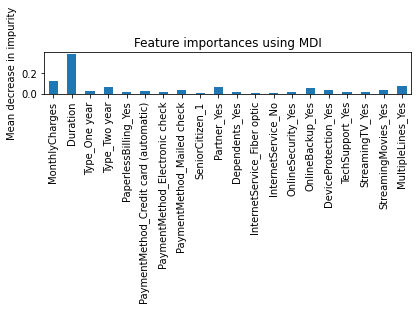

In [ ]:
# важность признаков в модели 
importances = best_model_forest.feature_importances_
std = np.std([best_model_forest.feature_importances_ for tree in best_model_forest.estimators_], axis=0)

feature_names = features_train_ohe.columns

forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

#### Логистическая регрессия

In [ ]:
%%time

# осуществим подбор параметров с помощью GridSearchCV 

lr_model = LogisticRegression(random_state=80523, class_weight='balanced')
parameters = {'C': [x for x in np.arange(0.5, 2.0, 0.25)], 
              'max_iter': [x for x in range(100, 1000, 100)],
              'solver': [x for x in ['liblinear', 'newton-cholesky', 'lbfgs']]}

grid_lr = GridSearchCV(lr_model, parameters, cv=5, scoring='roc_auc')
grid_lr.fit(features_train_ohe, target_train)
display(grid_lr.best_params_, grid_lr.best_score_)

{'C': 1.0, 'max_iter': 100, 'solver': 'lbfgs'}

0.7630065510789166

CPU times: user 1min 11s, sys: 1min 33s, total: 2min 45s
Wall time: 2min 46s


In [ ]:
# запишем лучшую модель
#best_lr_model = grid_lr.best_estimator_

In [ ]:
%%time

# обучаем модель на подобранных оптимальных гиперпараметрах
best_lr_model = LogisticRegression(C = 1.0, solver='lbfgs', max_iter = 100, random_state=80523, class_weight='balanced')
best_lr_model.fit(features_train_ohe, target_train)

cross_val_score(best_lr_model, features_train_ohe, target_train, scoring='roc_auc', cv=5).mean()

CPU times: user 1.02 s, sys: 1.68 s, total: 2.7 s
Wall time: 2.89 s


0.7630065510789166

In [ ]:
# записываем результаты для модели, расчитанные на кросс-валидации
# цикл проходит по списку метрик для оценки
for sc in sc_metrics:
    models_scores.loc[models_scores['model']=='best_log_regr', sc] = round(
        cross_val_score(best_lr_model, features_train_ohe, target_train, scoring=sc, cv=5).mean(), 4)

models_scores

model      f1  roc_auc  recall  precision  accuracy
0  best_forest_model  0.4932    0.831  0.6791     0.3875    0.7815
1      best_log_regr  0.4134    0.763  0.6707     0.2991    0.7020
2    best_lgbm_model  0.0000    0.000  0.0000     0.0000    0.0000
3     best_cat_model  0.0000    0.000  0.0000     0.0000    0.0000

#### LGBM Бустинг

In [ ]:
%%time

lgbm_model = LGBMClassifier(boosting_type = 'gbdt', class_weight = 'balanced', random_state=80523)

# подберем оптимальные гиперпараметры с помощью gridsearch по метрике roc_auc
parameters = {'n_estimators': [x for x in [350]],
              'learning_rate': [x for x in [0.1]], 
              'max_depth': [x for x in range(7, 9, 1)]}

grid_lgbm = GridSearchCV(lgbm_model, parameters, cv=5, scoring='roc_auc', n_jobs=-1)
grid_lgbm.fit(features_train_ohe, target_train)
display(grid_lgbm.best_params_, grid_lgbm.best_score_)

In [ ]:
%%time

best_lgbm_model = LGBMClassifier(boosting_type = 'gbdt',
                            class_weight = 'balanced',
                            max_depth=8,
                            n_estimators=350,
                            learning_rate=0.1)

best_lgbm_model.fit(features_train_ohe, target_train)

cross_val_score(best_lgbm_model, features_train_ohe, target_train, scoring='roc_auc', cv=5).mean()

CPU times: user 34.1 s, sys: 0 ns, total: 34.1 s
Wall time: 37.2 s


0.8924723162067101

In [ ]:
# записываем результаты для модели, расчитанные на кросс-валидации
# цикл проходит по списку метрик для оценки
for sc in tqdm(sc_metrics):
    models_scores.loc[models_scores['model']=='best_lgbm_model', sc] = round(
        cross_val_score(best_lgbm_model, features_train_ohe, target_train, scoring=sc, cv=5, n_jobs=-1).mean(), 4)

models_scores

100%|██████████| 5/5 [01:13<00:00, 14.70s/it]


model      f1  roc_auc  recall  precision  accuracy
0  best_forest_model  0.4932   0.8310  0.6791     0.3875    0.7815
1      best_log_regr  0.4134   0.7630  0.6707     0.2991    0.7020
2    best_lgbm_model  0.6271   0.8925  0.6174     0.6380    0.8851
3     best_cat_model  0.0000   0.0000  0.0000     0.0000    0.0000

#### Catboost Бустинг

Catboost работает с незакодированными категориальными переменными, поэтому передадим ему данные до кодирования ohe

In [ ]:
%%time

cat_model = CatBoostClassifier(cat_features=cat_feat, auto_class_weights='Balanced', random_state=80523)

# подберем оптимальные гиперпараметры с помощью gridsearch по метрике roc_auc
parameters = {'max_depth': [x for x in range(5, 11, 2)], 'n_estimators': [x for x in range(150, 401, 50)],
              'learning_rate': [x for x in [0.1]]}
 

grid_cat = GridSearchCV(cat_model, parameters, cv=5, scoring='roc_auc', n_jobs=-1)
grid_cat.fit(features_train, target_train)
display(grid_cat.best_params_, grid_cat.best_score_)

0:	learn: 0.6715038	total: 50.1ms	remaining: 7.47s
1:	learn: 0.6532369	total: 52.3ms	remaining: 3.87s
2:	learn: 0.6382565	total: 54.3ms	remaining: 2.66s
3:	learn: 0.6230246	total: 56.2ms	remaining: 2.05s
4:	learn: 0.6086266	total: 58ms	remaining: 1.68s
5:	learn: 0.5971131	total: 59.8ms	remaining: 1.43s
6:	learn: 0.5853338	total: 61.6ms	remaining: 1.26s
7:	learn: 0.5745052	total: 63.5ms	remaining: 1.13s
8:	learn: 0.5674720	total: 65ms	remaining: 1.02s
9:	learn: 0.5600628	total: 66.8ms	remaining: 935ms
10:	learn: 0.5534851	total: 68.6ms	remaining: 867ms
11:	learn: 0.5473340	total: 70.4ms	remaining: 810ms
12:	learn: 0.5410004	total: 72.3ms	remaining: 762ms
13:	learn: 0.5360970	total: 74.1ms	remaining: 720ms
14:	learn: 0.5323914	total: 76ms	remaining: 684ms
15:	learn: 0.5273414	total: 77.8ms	remaining: 652ms
16:	learn: 0.5247149	total: 79.2ms	remaining: 620ms
17:	learn: 0.5211858	total: 81.1ms	remaining: 595ms
18:	learn: 0.5176688	total: 82.9ms	remaining: 572ms
19:	learn: 0.5147886	total: 

{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 400}

0.9092789740758705

CPU times: user 3min 33s, sys: 23.5 s, total: 3min 57s
Wall time: 4min 58s


In [ ]:
%%time

# обучаем модель на подобранных оптимальных гиперпараметрах
best_cat_model = CatBoostClassifier(cat_features=cat_feat, auto_class_weights='Balanced', learning_rate=0.1, max_depth=5, n_estimators=400, random_state=80523)
best_cat_model.fit(features_train, target_train)

cross_val_score(best_cat_model, features_train, target_train, scoring='roc_auc', cv=5).mean()

0:	learn: 0.6628763	total: 6.92ms	remaining: 2.76s
1:	learn: 0.6366942	total: 13.1ms	remaining: 2.61s
2:	learn: 0.6176886	total: 18.9ms	remaining: 2.5s
3:	learn: 0.5999352	total: 25.2ms	remaining: 2.5s
4:	learn: 0.5865935	total: 31.1ms	remaining: 2.46s
5:	learn: 0.5752852	total: 37.5ms	remaining: 2.46s
6:	learn: 0.5647197	total: 43.6ms	remaining: 2.45s
7:	learn: 0.5544215	total: 50ms	remaining: 2.45s
8:	learn: 0.5464448	total: 56.4ms	remaining: 2.45s
9:	learn: 0.5391779	total: 62.9ms	remaining: 2.45s
10:	learn: 0.5329744	total: 68.8ms	remaining: 2.43s
11:	learn: 0.5291157	total: 74.6ms	remaining: 2.41s
12:	learn: 0.5230856	total: 80.5ms	remaining: 2.4s
13:	learn: 0.5196847	total: 86.2ms	remaining: 2.38s
14:	learn: 0.5133523	total: 92.6ms	remaining: 2.38s
15:	learn: 0.5098538	total: 98.3ms	remaining: 2.36s
16:	learn: 0.5066849	total: 105ms	remaining: 2.35s
17:	learn: 0.5043418	total: 111ms	remaining: 2.36s
18:	learn: 0.5024051	total: 116ms	remaining: 2.33s
19:	learn: 0.4998008	total: 12

0.9092789740758705

In [ ]:
# записываем результаты для модели, расчитанные на кросс-валидации
# цикл проходит по списку метрик для оценки
for sc in sc_metrics:
    models_scores.loc[models_scores['model']=='best_cat_model', sc] = round(
        cross_val_score(best_cat_model, features_train, target_train, scoring=sc, cv=5).mean(), 4)

0:	learn: 0.6657757	total: 5.64ms	remaining: 2.25s
1:	learn: 0.6435533	total: 10.7ms	remaining: 2.14s
2:	learn: 0.6179613	total: 16ms	remaining: 2.11s
3:	learn: 0.5993883	total: 20.8ms	remaining: 2.06s
4:	learn: 0.5856257	total: 25.6ms	remaining: 2.02s
5:	learn: 0.5711489	total: 30.7ms	remaining: 2.02s
6:	learn: 0.5590928	total: 35.5ms	remaining: 1.99s
7:	learn: 0.5500205	total: 40.3ms	remaining: 1.97s
8:	learn: 0.5428753	total: 44.9ms	remaining: 1.95s
9:	learn: 0.5363629	total: 49.3ms	remaining: 1.92s
10:	learn: 0.5317075	total: 53.3ms	remaining: 1.89s
11:	learn: 0.5238869	total: 57.7ms	remaining: 1.86s
12:	learn: 0.5197716	total: 61.2ms	remaining: 1.82s
13:	learn: 0.5153925	total: 65.3ms	remaining: 1.8s
14:	learn: 0.5109888	total: 70ms	remaining: 1.8s
15:	learn: 0.5059925	total: 74.8ms	remaining: 1.79s
16:	learn: 0.5024371	total: 79.3ms	remaining: 1.79s
17:	learn: 0.4994695	total: 84ms	remaining: 1.78s
18:	learn: 0.4955124	total: 88.7ms	remaining: 1.78s
19:	learn: 0.4939501	total: 93

In [ ]:
models_scores

model      f1  roc_auc  recall  precision  accuracy
0  best_forest_model  0.4932   0.8310  0.6791     0.3875    0.7815
1      best_log_regr  0.4134   0.7630  0.6707     0.2991    0.7020
2    best_lgbm_model  0.6271   0.8925  0.6174     0.6380    0.8851
3     best_cat_model  0.6284   0.9093  0.7639     0.5353    0.8582

**Выбор модели**:
По результатам кросс-валидационной оценки лучшей моделью по roc_auc стала модель catboost с оценкой 0.9. При этом catboost показывает лучший recall, чем другие модели, что важно для минимизации убытков (лучше давать промокод и ошибиться (потеря 30%), чем не дать и ошибиться (потеря 100%)). 

### Pipeline

Попробуем применить pipeline для улучшения результвтов моделей.

Снова подготовим выборки на основе объединенного датасета.

In [ ]:
# создадим признаки (X) и цель (Y) для выборок 
x = df.drop(['customerID', 'BeginDate', 'EndDate', 'EndMonth', 'Churn', 'TotalCharges', 'gender', 'Phone'], axis=1)
y = df['Churn']

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.25, random_state=80523, stratify=y)

#проверяем объемы выборок
display(x_train.shape, x_test.shape)

(5282, 16)

(1761, 16)

Сделаем пайплайны для моделей - логистической регрессии, случайного леса и бустинга

In [ ]:
# логистическая регрессия
get_categorical_data = FunctionTransformer(lambda x: x[['Type', 'PaperlessBilling', 'PaymentMethod', 'SeniorCitizen', 'Partner',
                                                       'Dependents', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
                                                       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
                                                       'MultipleLines']], validate = False)
get_numeric_data = FunctionTransformer(lambda x: x[['MonthlyCharges', 'Duration']], validate = False)

pipe_lr = Pipeline([
    ('union', FeatureUnion(
        transformer_list = [
            ('numeric_features', Pipeline([("selector", get_numeric_data),('scaler', StandardScaler())])),   
            ('categorical_features', Pipeline([("selector", get_categorical_data),('ohe', OneHotEncoder(drop='first'))]))],)), 
            ('model_lr', LogisticRegression(random_state=80523, class_weight='balanced'))])
model_lr = pipe_lr.fit(x_train, y_train)

In [ ]:
# roc_auc кроссвалидацией
n_scores = cross_val_score(model_lr, x_train, y_train, scoring='roc_auc', cv=5)
final_score_lr = n_scores.mean()
final_score_lr

0.7630092846602861

In [ ]:
# случайный лес

pipe_rf = Pipeline([
    ('union', FeatureUnion(
        transformer_list = [
            ('numeric_features', Pipeline([("selector", get_numeric_data),('scaler', StandardScaler())])),   
            ('categorical_features', Pipeline([("selector", get_categorical_data),('ohe', OneHotEncoder(drop='first'))]))],)), 
            ('model_rf', RandomForestClassifier(random_state=80523, class_weight='balanced'))])
model_rf = pipe_rf.fit(x_train, y_train)

In [ ]:
# roc_auc кроссвалидацией
n_scores = cross_val_score(model_rf, x_train, y_train, scoring='roc_auc', cv=5)
final_score_rf = n_scores.mean()
final_score_rf

0.8066763433117202

In [ ]:
# lgbm

pipe_lgb = Pipeline([
    ('union', FeatureUnion(
        transformer_list = [
            ('numeric_features', Pipeline([("selector", get_numeric_data),('scaler', StandardScaler())])),   
            ('categorical_features', Pipeline([("selector", get_categorical_data),('ohe', OneHotEncoder(drop='first'))]))],)), 
            ('model_lgb', LGBMClassifier(random_state=80523, class_weight='balanced'))])
model_lgb = pipe_rf.fit(x_train, y_train)

In [ ]:
# roc_auc кроссвалидацией
n_scores = cross_val_score(model_lgb, x_train, y_train, scoring='roc_auc', cv=5)
final_score_lgb = n_scores.mean()
final_score_lgb

Добавляем GridSearchCV

In [ ]:
%%time

# параметры gridsearch
grid_params_lr = [{'model_lr__C': [x for x in np.arange(0.25, 2.25, 0.25)], 
                   'model_lr__max_iter': [x for x in range(100, 1000, 100)],
                   'model_lr__solver': ['liblinear','newton-cholesky', 'lbfgs']}] 


grid_params_rf = [{'model_rf__max_depth': [x for x in range(6, 10, 2)],
                   'model_rf__n_estimators': [x for x in range(105, 206, 10)]}]

grid_params_lgb = [{'model_lgb__max_depth': [x for x in range(6, 11, 2)],
                   'model_lgb__n_estimators': [x for x in range(300, 401, 25)],
                   'model_lgb__learning_rate': [x for x in [0.1]]}]


LR = GridSearchCV(estimator=pipe_lr,
            param_grid=grid_params_lr,
            scoring='roc_auc',
            cv=5, n_jobs=-1) 

RF = GridSearchCV(estimator=pipe_rf,
            param_grid=grid_params_rf,
            scoring='roc_auc',
            cv=5, n_jobs=-1)

#LGB = GridSearchCV(estimator=pipe_lgb,
            param_grid=grid_params_lgb,
            scoring='roc_auc',
            cv=5, n_jobs=-1)

#список пайплайнов для итерирования
grids = [LR,RF] #,LGB]

#соответствие моделей
grid_dict = {0: 'Logistic Regression', 
        1: 'Random Forest'} #,
        #2: 'Light Boosting'}

#задаем нулевые значения
display('Процесс оптимизации..')
best_roc_auc = 0.0
best_clf = 0
best_gs = ''

'Процесс оптимизации..'

CPU times: user 2.24 ms, sys: 432 µs, total: 2.67 ms
Wall time: 1.72 ms


In [ ]:
%%time

for idx, gs in tqdm(enumerate(grids)):
    display('\nEstimator: %s' % grid_dict[idx])
    gs.fit(x_train, y_train)
    display('Best params are : %s' % gs.best_params_)
    # Best training data accuracy
    display('Best training roc_auc: %.3f' % gs.best_score_)
    # Predict on test data with best params
    y_pred = gs.predict(x_test)
    # Test data accuracy of model with best params
    display('Test set roc_auc score for best params: %.3f ' % roc_auc_score(y_test, y_pred))
    # Track best (highest test accuracy) model
    if roc_auc_score(y_test, y_pred) > best_roc_auc:
        best_roc_auc = roc_auc_score(y_test, y_pred)
        best_gs = gs
        best_clf = idx
display('\nClassifier with best test set roc_auc: %s' % grid_dict[best_clf])

0it [00:00, ?it/s]

'\nEstimator: Logistic Regression'

"Best params are : {'model_lr__C': 1.0, 'model_lr__max_iter': 100, 'model_lr__solver': 'lbfgs'}"

'Best training roc_auc: 0.763'

'Test set roc_auc score for best params: 0.668 '

1it [00:52, 52.42s/it]

'\nEstimator: Random Forest'

"Best params are : {'model_rf__max_depth': 8, 'model_rf__n_estimators': 195}"

'Best training roc_auc: 0.829'

'Test set roc_auc score for best params: 0.708 '

2it [02:34, 77.04s/it]


'\nClassifier with best test set roc_auc: Random Forest'

CPU times: user 2min 28s, sys: 1.44 s, total: 2min 29s
Wall time: 2min 34s


## Тестирование выбранной модели

### Проверка на тестовой выборке

In [ ]:
%%time

predict_test = best_cat_model.predict_proba(features_test)

roc_auc_score(target_test, predict_test[:,1])

CPU times: user 9.73 ms, sys: 0 ns, total: 9.73 ms
Wall time: 8.61 ms


0.8947375504710632

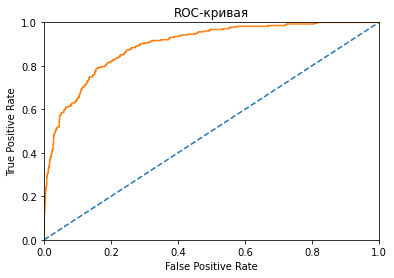

In [ ]:
# построим кривую Roc curve
probabilities_one_test = predict_test[:, 1]

fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)

plt.figure()

# ROC-кривая случайной модели (выглядит как прямая)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr)

# < примените функции plt.xlim() и plt.ylim(), чтобы
#   установить границы осей от 0 до 1 >
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

# < примените функции plt.xlabel() и plt.ylabel(), чтобы
#   подписать оси "False Positive Rate" и "True Positive Rate" >
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# < добавьте к графику заголовок "ROC-кривая" функцией plt.title() >
plt.title('ROC-кривая')

plt.show()

**Roc_auc 0.895 на тестовой выборке**, порог заказчика метрики в 0.85 преодолен, модель может быть использована для предсказания оттока клиентов.

### Проверка модели на адекватность

Чтобы оценить адекватность модели в задачах классификации, сравним ее с DummyClassifier

In [ ]:
#проверяем модель на адекватность 
dummy_clf = DummyClassifier(strategy="stratified")
dummy_clf.fit(features_train_ohe, target_train)

probabilities_test = dummy_clf.predict_proba(features_test)
probabilities_one_test_dummy = probabilities_test[:, 1]

display('AUC_ROC: {:.4f}'.format(roc_auc_score(target_test, probabilities_one_test_dummy)))

'AUC_ROC: 0.5008'

Модель DummyClassifier показала существенно более низкий результат на тестовой выборке (auc-roc=0.51), подтвердив адекватность отобранной модели.

###  Оценка влияния предсказаний на бизнес метрики

In [ ]:
# посмотрим пример предсказаний
predict_test

array([[0.98811061, 0.01188939],
       [0.64495373, 0.35504627],
       [0.21264875, 0.78735125],
       ...,
       [0.99642915, 0.00357085],
       [0.91170747, 0.08829253],
       [0.92769511, 0.07230489]])

In [ ]:
# предскажем класс
predict_class = best_cat_model.predict(features_test)
predict_class = pd.Series(predict_class,target_test.index)
predict_class

908     0
2130    0
6814    1
6080    0
905     0
       ..
3778    0
6438    0
4930    0
4681    0
6872    0
Length: 1761, dtype: int64

In [ ]:
# выведем основные метрики, полученные на тесте
precision_test = precision_score(target_test, predict_class)
recall_test = recall_score(target_test, predict_class)
roc_auc_test = roc_auc_score(target_test, predict_class)
f1_test = f1_score(target_test, predict_class)

display("Точность = {:.3f}, Полнота = {:.3f} | Roc_Auc = {:.3f} | F1 = {:.3f} ".format(
    precision_test, recall_test, roc_auc_test, f1_test))

'Точность = 0.505, Полнота = 0.745 | Roc_Auc = 0.805 | F1 = 0.602 '

In [ ]:
# соединим целевой признак на тестовой выборке, предсказание и оплату за месяц в одном датасете
b_m = pd.DataFrame(data=[target_test, predict_class]).T
b_m.columns=['target','prediction']
b_m['index'] = b_m.index

m_charges = df_contract['MonthlyCharges']
m_charges = pd.DataFrame(data=[m_charges]).T
m_charges.columns=['MonthlyCharges']
m_charges['index'] = m_charges.index

m_charges
b_m = b_m.merge(m_charges, how='left', on='index')
display(b_m.shape, target_test.shape)
b_m.head()

(1761, 4)

(1761,)

target  prediction  index  MonthlyCharges
0       0           0    908           19.95
1       1           0   2130           94.80
2       1           1   6814           94.00
3       0           0   6080           29.70
4       0           0    905          100.50

In [ ]:
#посчитаем ошибки 
b_m['error']=b_m['target']-b_m['prediction']
display('Количество ошибок', abs(b_m['error']).sum(), 
        '% ошибок от тестовой выборки', round(abs(b_m['error']).sum()/target_test.shape[0], 2))

'Количество ошибок'

271

'% ошибок от тестовой выборки'

0.15

In [ ]:
b_m['error'].unique()

array([ 0,  1, -1])

In [ ]:
display('False Negative', b_m.loc[b_m['error']==1]['index'].count(),
        'False Positive', b_m.loc[b_m['error']==-1]['index'].count())

'False Negative'

70

'False Positive'

201

Из предсказаний 1761 тестового значения целевого признака модель ошиблась 271 раз (15% от объема предсказаний). Из них:
- 70 раз: 1 - ошибка второго рода, False Negative, клиент собирался уйти и остался без промокода. В этом случае убытки компании 100% от MonthlyCharges
- 201 раз: -1 - ошибка первого рода, False Positive, клиент не собирался уйти, но ему дали промокод. В этом случае убытки компании 30% от MonthlyCharges

Среди предсказаний модели больше ложноположительных ошибок (клиент собирался уйти, но не получил промокод), т.е. 30% потеря MonthlyCharges в краткосрочной перспективе

In [ ]:
# посчитаем сумму убытков для обеих ошибок и их сумму
display('FN_loss', b_m.loc[b_m['error']==1]['MonthlyCharges'].sum(), 
        'FP_loss', b_m.loc[b_m['error']==-1]['MonthlyCharges'].sum() * 0.3,
        'total_loss', b_m.loc[b_m['error']==1]['MonthlyCharges'].sum()+b_m.loc[b_m['error']==-1]['MonthlyCharges'].sum()*0.3)
total_loss = b_m.loc[b_m['error']==1]['MonthlyCharges'].sum()+b_m.loc[b_m['error']==-1]['MonthlyCharges'].sum()*0.3

'FN_loss'

4734.499999999999

'FP_loss'

4704.179999999999

'total_loss'

9438.679999999998

In [ ]:
# посчитаем сколько модель принесла максимальной потенциальной прибыли 
# посчитаем как 0,7 от MonthlyCharges для случаев, где клиент хотел уйти, но получил промокод  
display('True exit predictions', b_m.loc[(b_m['target']==1)&(b_m['prediction']==1)]['MonthlyCharges'].count(),
        'potential value', b_m.loc[(b_m['target']==1)&(b_m['prediction']==1)]['MonthlyCharges'].sum() * 0.7)
pot_value = b_m.loc[(b_m['target']==1)&(b_m['prediction'])]['MonthlyCharges'].sum() * 0.7

'True exit predictions'

205

'potential value'

11491.409999999998

In [ ]:
# посчитаем потенциальные убытки компнаии за вычетом прибыли от сохраненных клиентов
display('reduced_loss', total_loss - pot_value, 
        '%_reduce', (total_loss - pot_value)/total_loss)

'reduced_loss'

-2052.7299999999996

'%_reduce'

-0.217480622290405

In [ ]:
# посчитаем полный объем убытков от ушедшх клиентов без внедрения модели
b_m.loc[(b_m['target']==1)]['MonthlyCharges'].sum()

21150.799999999996

**Оценка**: 
- возможные убытки от некорректных предсказаний составили 9438.7, поровну разделившись между ошибками первого и второго рода..
- потенциальная прибыль (оптимистичный сценарий, где каждый промокод подействовал) 11 491
- потенциальная (максимальная) прибыль больше возможного убытка от предсказаний, при внедрении модели компания выиграет до 2000 дополнителььного дохода 

При этом, без внедрения модели, предсказывающей отток, и раздачи промокодов, убыток от ушедших клиентов составил бы 21 151. Выгода от внедрения модели значительна.

Минимизацию убытков удалось осуществить засчет высокого показателя Recall у выбранной модели. Попробуем поменять порог классификации и посмотреть, как меняются показатели.

In [ ]:
# посчитаем для разных порогов классификации

for threshold in tqdm(np.arange(0.5, 1.0, 0.1)):
    predicted_test = probabilities_one_test > threshold  
    precision = precision_score(target_test, predicted_test)
    recall = recall_score(target_test, predicted_test)
    roc_auc = roc_auc_score(target_test, predicted_test)
    f1 = f1_score(target_test, predicted_test)

    display("Порог = {:.2f} | Точность = {:.3f}, Полнота = {:.3f} | Roc_Auc = {:.3f} | F1 = {:.3f} ".format(
        threshold, precision, recall, roc_auc, f1))

  0%|          | 0/5 [00:00<?, ?it/s]

'Порог = 0.50 | Точность = 0.505, Полнота = 0.745 | Roc_Auc = 0.805 | F1 = 0.602 '

'Порог = 0.60 | Точность = 0.561, Полнота = 0.636 | Roc_Auc = 0.772 | F1 = 0.596 '

'Порог = 0.70 | Точность = 0.687, Полнота = 0.575 | Roc_Auc = 0.763 | F1 = 0.626 '

'Порог = 0.80 | Точность = 0.744, Полнота = 0.422 | Roc_Auc = 0.697 | F1 = 0.538 '

'Порог = 0.90 | Точность = 0.889, Полнота = 0.233 | Roc_Auc = 0.614 | F1 = 0.369 '

100%|██████████| 5/5 [00:00<00:00, 164.62it/s]


Модель с дефолтным уровнем порога показывает лучший результат по Полноте и Roc_auc.

## **Отчет по проекту**

В рамках проекта решалась задача классификации, необходимо предсказать склонен ли клиент к уходу из компании. 
В распоряжении клиента (телеком компания «Ниединогоразрыва.ком») имеются данные о клиентах, представленные 4 базами:
- база с информацией об условиях контракта (contract_new.csv);
- база с информацией о персональных данных клиента (personal_new.csv); 
- информация об интернет-услугах (internet_new.csv);
- информация об услугах телефонии (phone_new.csv).

Клиент планирует использовать модель для предсказания ухода недовольных клиентов, которым заранее будет предложен купон на 30% скидку от платы за месяц.

Модель будет оцениваться заказчиком по двум направлениям: 
1. метрика ROC_AUC не ниже 0.85
2. Бизнес-метрика - минимизация возможных убытков от ухода клиентов. В случае некорректного прогноза потери будут рассчитываться по ошибкам первого (дали промокод и без того лояльному клиенту, потеря 30% от оплаты клиента), и второго рода (модель не предсказала уход недовольного клиента, убыток 100% оплаты за месяц). Чтобы минимизировать ошибки второго рода, модель должна стремиться к увеличению Recall метрики.

Основные этапы проекта:
- предобработка данных
- исследовательский анализ данных
- построение моделей
- тестирование лучшей модели и расчет бизнес-метрик

### Предобработка данных

На вход было получено 4 базы данных, каждая из которых имела признак customerID, индивидуальный идентификатор клиента. Первые две базы содержали в себе 7043 наблюдения, интернет-услуги - 5517 и телефония - 6361.
Целевой признак (уход клиента) не выделен.

Базы данных хорошего качества, без дубликатов (явных и неявных), аномалий, с минимум пропусков (11 пропусков у признака TotalCharges (Общие Расходы клиента за все время обслуживания) - для новых клиентов, которые начали обсулуживаться менее месяца назад)).
Для новых клиентов пропуски TotalCharges были заполнены 0.

Выгрузка баз была произведена в феврале 2020 года, все актуальные клиенты не иели заполненной даты в EndDate (дата окончания обслуживания клиента). Это позволило выделить целевой признак, получивший название Churn, как 1 для всех наблюдений, имеющих дату в EndDate и 0 для наблюдений без даты ухода. После этого все отсутствующие значения дат в EndDate были заполнены датой выгрузки - 2020-02-01.

После восполнения пропусков и дат были изменены некорректные форматы для TotalCharges (на float) и BeginDate, EndDate (дат начала и окончания обслуживания контракта - на Datetime). На основе дат было добавлено два новых признака - длительность контракта в днях (разница между EndDate и BeginDate) Duration и месяц ухода клиента EndDate.

После завершения предобработки базы были объединены по идентификатору customerID, в основу легла база с данными по контракту, в которой содержался целевой признак оттока и которая должна была войти в объединенную базу полностью. Все идентификаторы совпали, коненчый объем объединенной базы - 7043 наблюдения. Образовавшиеся пропуски для пользователей без интернет услуг и телефонии были заполнены 'No', не пользуются.

### Исследовательский анализ данных. 

1. Для последовательного анализа признаков было использовано профилирование Pandas Profiling. Были исследованы:
- распределения значений для категориальных переменных, в основном бинарных: информация о типах платежей, демографии, пользовании услугами.
- распределение и размах значений количественных признаков

2. Был исследован дисбаланс классов и разница в распределении всех качественных и количественных признаков для оставшихся клиентов (класс 0) и ушедших клиентов (класс 1). В результате были сделаны **выводы**: 
- предварительная картина вырисовывается неутешительной, в целом портрет ушедшего пользователя оказывается более привлекательным для бизнеса, чем оставшихся: компания в большей степени теряет более активных потребителей сервисов и услуг. 
- И с точки зрения финансовой надежности, ушедшие клиенты в среднем обладали более привлекательным "поведением", чем оставшиеся (в основной массе). 
- Ушедшие показывали более высокое медианное значение как по размеру платы за месц, так и по продолжительности обсулуживания.

3. Была проведена оценка корреляции признаков для количественных и категориальных признаков (Phik корреляция). **Выводы**: 
- Наиболее заметная между TotalCharges и MonthlyCharges, Duration, что логично: чем дольше клиент и чем больше он платит за месяц - тем больше будут его расходы. 
- Самая сильная корреляция целевого признака Churn наблюдается c продолжительностью (0.37), т.е. чем дольше клиент обслуживается, тем вероятнее, что он скоро уйдет, но связь по силе ниже среднего. Напротив признаки gender и phone показали практически нулевое влияние на целевой признак.
- Плата за месяц в большей степени определяется пользованием интернетом, стримингами и телефоном (сильная корреляция 0.83-0.91), оставшийся набор услуг - средняя по силе корреляция (0.55-0.67). Наибольшее влияние на продолжительность договора имеет тип оплаты, а значит этот признак важен и для предсказания оттока. В свою очередь на тип оплаты влияет значение признак InternetService.
- По итогам оценки взаимосвязей было принято решение удалить признаки TotalCahrges (чтобы избежать мультиколлинеарности), Gender и Phone (нулевое влияние на Churn)

4. Было провдено исследование возможности выделения отдельных кластеров клиентов на основе комбинации разных признаков (платы за месяц, продолжительнсоти обсулуживания и категориальных признаков). 

### Построение моделей
В проекте были обучены 4 модели 3х типов:
- Случайный лес
- Логистическая регрессия
- Бустинг: LGBM и Catboost

Выборки сформированы по следующим условиям:
- целевой признак (target) - Churn
- признаки для обучения (features) - 14 категориальных признаков и 2 количественных:

#### Признаки для обучения
**Категориальные признаки** для обучения:
1. 'Type',
2. 'PaperlessBilling',
3. 'PaymentMethod',
4. 'SeniorCitizen',
5. 'Partner',
6. 'Dependents',
7. 'InternetService',
8. 'OnlineSecurity',
9. 'OnlineBackup',
10. 'DeviceProtection',
11. 'TechSupport',
12. 'StreamingTV',
13. 'StreamingMovies',
14. 'MultipleLines'

**Количественные признаки** для обучения:
1. Duration
2. MonthlyCharges

Признаки TotalCharges, gender, Phone были удалены из выборок по результатам оценки корреляции, BeginDate, EndDate, customerID,EndMonth были удалены как служебные и бесполезные для обучения.

#### Подготовка выборок
- при разделении выборок, 25% датасета ушло в тестовую выборку
- были использован параметр stratify=target
- при разделении и далее При обучении моделей использовался **random_state = 80523**

- далее количественные данные были промасштабировны OneScaler (обучен на обучающей выборке)
- категориальные признаки были закодированы OHE (кодировщик обучен на обучающей выборке), благо большая часть признаков бинарные

#### Оценки 4 моделей кросс-валидацией:
Для подбора параметров использовался GridSearchCV с оценкой roc_auc кроссвалидацией.
Для борьбы с дисбаланс исользовался параметр class_weight='balanced'

В результате 4 модели получили следующие параметры для обучения:

*Случаный лес*:
{'max_depth': 7, 'n_estimators': 145}

*Логистическая регрессия*:
{'C': 1.0, 'max_iter': 100, 'solver': 'lbfgs'}

*Бустинг lgbm*:
{'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 350}

*Бустинг catboost*:
{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 400}

#### Отобранная модель
Лучшие показатели по roc_auc и recall показала модель **catboost** (0.91 и 0.76 соответственно).

Для обучения использовались гиперпараметры и балансировка классов auto_class_weight='Balanced':

**{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 400}**


### Тестирование лучшей модели
#### Проверка Roc-Auc

В результате проверки модели catboost на Тестовой выборке, был достигнут roc_auc 0.9. Т.е. успешно пройден порог от заказчика в 0.85.

А также были достигнуты следующие метрики:
- Precision = 0.505
- Recall = 0.745 
- F1 = 0.602

Модель прошла успешную проверку на адекватность в сравнении с DummyClassifier

#### Оценка бизнес-метрик
- возможные убытки от некорректных предсказаний составили 9438.7, поровну разделившись между ошибками первого и второго рода..
- потенциальная прибыль (оптимистичный сценарий, где каждый промокод подействовал) 11 491
- потенциальная (максимальная) прибыль больше возможного убытка от предсказаний, при внедрении модели компания выиграет до 2000 дополнителььного дохода 

При этом, без внедрения модели, предсказывающей отток, и раздачи промокодов, убыток от ушедших клиентов составил бы 21 151. Выгода от внедрения модели значительна.

Минимизацию убытков удалось осуществить засчет высокого показателя Recall у выбранной модели.

### Вывод
Модель соответствует требованиям заказчика и рекомендована к применению.